In [2]:
import os
import numpy as np
import scipy as sp
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import keras
from scipy.stats import truncnorm
from scipy.stats import truncexpon
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from keras import backend as K
from keras.models import Sequential
from keras.layers import Flatten,Conv2D,Dropout,Input,Dense,MaxPooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from keras.wrappers.scikit_learn import KerasClassifier
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示中文标签
from ERANataf import ERANataf
from ERADist import ERADist
from SuS import SuS
# from SuS_0 import SuS
from joblib import Parallel, delayed
from shutil import copy
plt.close('all')

In [3]:
"""
---------------------------------------------------------------------------
Subset Simulation: 简单自然循环案例: y = RELAP5(cond_h, cond_area)
---------------------------------------------------------------------------
"""
def alter(filepath, search_str, old_str, new_str):
  """
  替换文件中的字符串
  filepath:文件名
  search_str:搜索位置
  old_str:旧字符串
  new_str:新字符串
  """
  file_data = ''
  with open(filepath, 'r', encoding="utf-8") as f:
      for line in f:
          if search_str in line:
              line = line.replace(old_str, new_str)
          file_data += line
  with open(filepath, 'w', encoding="utf-8") as f:
      f.write(file_data)

def rewrite_line(filepath, search_str, new_line):
  """
  重写文件中的某一行
  filepath:文件名
  search_str:搜索位置
  new_line:新的内容
  """
  file_data = ''
  with open(filepath, 'r', encoding="gbk") as f:
      for line in f:
          if search_str in line:
              line = new_line
          file_data += line
  with open(filepath, 'w', encoding="gbk") as f:
      f.write(file_data)

def run_relap(filepath, i_name):
  """
  运行RELAP5
  filepath:relap5所在位置
  i_name:i文件名称
  """
  o_name = i_name.replace('.i','.o')
  r_name = i_name.replace('.i','.r')
  os.chdir(filepath)
  parameter = "%s\\relap5.exe -i %s -o %s -r %s"%(filepath, i_name, o_name, r_name)

  if os.path.exists(o_name):
      # print("%s is exist"%(o_name))
      os.remove(o_name)
      os.remove(r_name)
                  
  # os.popen(parameter)
  os.system(parameter)

def restart_relap(filepath, i_name, r_name):
  """
  运行RELAP5
  filepath:relap5所在位置
  i_name:i文件名称
  """
  o_name = i_name.replace('.i','.o')
  os.chdir(filepath)
  parameter = "%s\\relap5.exe -i %s -o %s -r %s"%(filepath, i_name, o_name, r_name)

  if os.path.exists(o_name):
      # print("%s is exist"%(o_name))
      os.remove(o_name)
                  
  os.system(parameter)

def mkstripf(filepath, r_name):
  """
  生成stripf文件
  filepath:relap5所在位置
  r_name:r文件名称
  """
  i_name = "strip-1.i"
  o_name = "strip-1.o"
  os.chdir(filepath)
  parameter = "%s\\relap5.exe -i %s -o %s -r %s"%(filepath,i_name,o_name,r_name)

  if os.path.exists(o_name):
      # print("strip-1.o is exist")
      os.remove(o_name)
      os.remove('stripf')
  
  # os.popen(parameter)
  os.system(parameter)
  # time.sleep(0.5)

def mkdir(filepath):
  """ 创建给定路径的文件夹 """
  try:
      os.mkdir(filepath)
      # print(filepath+" has been successfully created!")
  except:
      if os.path.exists(filepath):
          print(filepath+" already exist!")
      else:
          print(filepath+" error!")

def copy_irelap5(from_path, to_path, i_name, r_name):
  """
  备份.i relap5相关文件
  from_path:文件原位置
  to_path:文件要备份到的位置
  i_name:i文件名称
  """
  i_f_path = from_path + '\\' + i_name
  r_f_path = from_path + '\\' + r_name
  f_path_1 = from_path + '\\relap5.exe'
  f_path_2 = from_path + '\\glut32.dll'
  f_path_3 = from_path + '\\strip-1.i'
  f_path_4 = from_path + '\\tpfh2o'
  # i_t_path = to_path + '\\' + i_name
  # 备份位置删除已存在的文件
  # if os.path.exists(i_t_path):
      # print("i o stripf_file is exist")
      # os.remove(i_t_path)
  #     os.remove(o_t_path)
  #     os.remove(stripf_t_path)
  copy(i_f_path, to_path)
  copy(r_f_path, to_path)
  copy(f_path_1, to_path)
  copy(f_path_2, to_path)
  copy(f_path_3, to_path)
  copy(f_path_4, to_path)


def stripf2csv(FromFile,TargetFile):
  """ 从FromFile中读取stripf文件,将读取的文件以csv格式输出到TargetFile中 """
  # 本脚本用于从relap5mod3.5中stripf文件中提取数据

  stripf_file = FromFile
  with open(stripf_file,"r") as f:
      temp = f.readlines()
  #print(type(temp[1]))
  #print(temp[3])

  #读取变量列表
  strip_names = temp[3].replace(" plotalf-plotnum","")
  #print(strip_names.split())
  strip_names = strip_names.split()

  #读取变量数据
  a = []
  for data in temp[4:]:
      data = data.replace("plotrec","")
      a.append(data.split())
  strip_datas = np.array(a,dtype=float)

  # print(strip_datas.shape)
  # print(len(temp[4:]),len(strip_names))
  # strip_datas = np.transpose(strip_datas)

  #判断数据是否为空，如果是则添加无用数据0
  if len(temp[4:]) == 0:
      print('Input data missing!')
      strip_datas = np.zeros((1, len(strip_names)))

  #保存数组到csv
  pd.DataFrame(strip_datas).to_csv(TargetFile,header=strip_names,index=None)
  return strip_names,strip_datas

def csv_plot(FromFile,TargetFile):
  """ 本函数用于从csv中画图 """
  df = pd.read_csv(FromFile,sep=",")
  names = df.columns.values
  time = df.iloc[:,0].values
  for i in range(1,len(names)):
      temp = df.iloc[:,i].values
      plt.figure(figsize=(16,10),dpi=200)
      plt.plot(time,temp,linewidth=1.2,color="black")
      plt.xlabel("time")
      plt.ylabel(names[i])
      plt.savefig(TargetFile+"\\"+names[i]+".jpg")
      plt.close()
  return df,time

def relap_calculate(copy_dir, i_name, r_name, i):
  # 运行relap5
  # OutDir = copy_dir + '\\No.%d'%(i)
  OutDir = copy_dir + '\\testNo.%d'%(i)
  # o_path = OutDir + '\\' + i_name.replace('i','o')
  # r_path = OutDir + '\\' + i_name.replace('i','r')
  # print('No.%d calculating'%(i))
  restart_relap(OutDir, i_name, r_name)
  # print('No.%d calculation completed'%(i))
  # return(i)

def mkstripf_calculate(copy_dir, r_name, i):
  # 运行relap5
  # OutDir = copy_dir + '\\No.%d'%(i)
  copy_to_path = copy_dir + '\\testNo.%d'%(i)
  mkstripf(copy_to_path, r_name)
  # print('No.%d calculation completed'%(i))
  # return(i)

def latin_hypercube(n, d):
    """
    生成拉丁超立方抽样点集合

    Args:
        n: 抽样点数量
        d: 维度

    Returns:
        返回一个形状为 (n, d) 的 NumPy 数组，其中包含 n 个 d 维均匀分布的抽样点
    """
    # 生成均匀分布的样本点
    x = np.zeros((n, d))
    # for i in range(d):
    #     x[:, i] = np.random.uniform(size=n)
    # 对每一列进行排列
    for i in range(d):
        order = np.random.permutation(range(n))
        x[:, i] = (order + np.random.uniform(size=n)) / n
    return x

def RELAP5(u):
    # 路径
    i_name = 'test_rt.i'  # i文件名称
    r_name = 'test(9.16s).r'  # r文件名称
    OutDir = r'D:\relap5-2\TEST'  # relap5路径
    # OutDir = r'C:\Users\admin\Desktop\RELAP5-4'  # relap5路径
    i_path = OutDir + '\\' + i_name  # i文件路径
    o_path = OutDir + '\\' + i_name.replace('.i','.o')  # o文件路径
    r_path = OutDir + '\\' + r_name  # r文件路径
    search_str = 'Transient terminated by failure'  # 计算失败关键词
    stripf_path = OutDir + '\\stripf'  # stripf文件路径
    copy_dir = r'D:\copydir'  # 备份.i .o stripf的路径
    csv_path = r'D:\relap5-2\TEST\图表'  # 保存csv文件的路径
    # Tmax_path = r'C:\Users\admin\Desktop\ICS\图表\T_max 0-9.csv'  # 统计数据路径

    # 复制所需的文件到指定文件夹
    N = len(u)
    print('N = %d'%(N))

    for i in range(N):
        from_path = OutDir
        copy_to_path = copy_dir + '\\testNo.%d'%(i)
        mkdir(copy_to_path)
        copy_irelap5(from_path, copy_to_path, i_name, r_name)

    
    for i in range(N):
    # 修改输入卡
        i_path = copy_dir + '\\testNo.%d'%(i) + '\\' + i_name

        rewrite_line(i_path, '13651801', '13651801  0.0 10.0 10.0 0.0  0.0  0.0  0.0 1.0 0.0 1.1 %.3f 6'%(u[i, 0]) + '\n')
        rewrite_line(i_path, '13651901', '13651901  0.0 10.0 10.0 0.0  0.0  0.0  0.0 1.0 0.0 1.1 %.3f 6'%(u[i, 0]) + '\n')

        rewrite_line(i_path, '13651501', '13651501 365010000  10000 1 1 %.3f 6'%(u[i, 1]) + '\n')
        rewrite_line(i_path, '13651601', '13651601 350060000 -10000 1 1 %.3f 6'%(u[i, 1]) + '\n')

    # 并行计算
    numbers = list(range(N))
    Parallel(n_jobs = 18)(delayed(relap_calculate)(copy_dir, i_name, r_name, i) for i in numbers)
    
    # stripf提取数据
    numbers = list(range(N))
    Parallel(n_jobs = 18)(delayed(mkstripf_calculate)(copy_dir, r_name, i) for i in numbers)

    T_max = np.zeros([N, 1])
    for i in range(N):
      # 提取stripf数据到csv文件中
      copy_to_path = copy_dir + '\\testNo.%d'%(i)
      from_path = copy_to_path + '\\stripf'
      target_path = csv_path + '\\testNo.%d.csv'%(i)
      stripf2csv(from_path, target_path)
      # print(i)
      # 提取最大壁面温度
      df = pd.read_csv(target_path)
      data= df.values
      T_data = data[:, 1]
      T_max[i] = max(T_data)
    
    return(T_max)

In [ ]:
# 方法1：神经网络

In [3]:
# 生成用于训练神经网络的数据集

N = 100
d = 2
random_seed = latin_hypercube(N, d)

# 传热系数修改
# cond_h = np.random.normal(1.0, 0.2, size = (N, 1))
# cond_h = random_seed[:, 0]*1.96 + 0.02
# cond_h = truncnorm.ppf(random_seed[:, 0], a = -2, b = 2, loc = 1, scale = 0.49)
cond_h = truncexpon.ppf(random_seed[:, 0], b = 0.2, loc = 0.02, scale = 1)

# 换热面积修改
# cond_harea = np.random.normal(1.0, 0.2, size = (N, 1)) * 20
# cond_harea = random_seed[:, 1]*1.96 + 0.02
# cond_harea = truncnorm.ppf(random_seed[:, 1], a = -2, b = 2, loc = 1, scale = 0.49)
cond_harea = truncexpon.ppf(random_seed[:, 1], b = 0.2, loc = 0.02, scale = 1)

inputdatas = np.hstack((cond_h.reshape(-1,1), cond_harea.reshape(-1,1)))
res_out = inputdatas
# res_out = cond_h
header = ['cond_h', 'cond_harea']
TargetFile = 'C:/Users/JH/Desktop/inputdatas 100(expon2).csv'  #(改)
pd.DataFrame(res_out).to_csv(TargetFile, header = header, index = None)

In [4]:
y_100 = 440 - RELAP5(res_out)

N = 100
D:\copydir\testNo.0 already exist!
D:\copydir\testNo.1 already exist!
D:\copydir\testNo.2 already exist!
D:\copydir\testNo.3 already exist!
D:\copydir\testNo.4 already exist!
D:\copydir\testNo.5 already exist!
D:\copydir\testNo.6 already exist!
D:\copydir\testNo.7 already exist!
D:\copydir\testNo.8 already exist!
D:\copydir\testNo.9 already exist!
D:\copydir\testNo.10 already exist!
D:\copydir\testNo.11 already exist!
D:\copydir\testNo.12 already exist!
D:\copydir\testNo.13 already exist!
D:\copydir\testNo.14 already exist!
D:\copydir\testNo.15 already exist!
D:\copydir\testNo.16 already exist!
D:\copydir\testNo.17 already exist!
D:\copydir\testNo.18 already exist!
D:\copydir\testNo.19 already exist!
D:\copydir\testNo.20 already exist!
D:\copydir\testNo.21 already exist!
D:\copydir\testNo.22 already exist!
D:\copydir\testNo.23 already exist!
D:\copydir\testNo.24 already exist!
D:\copydir\testNo.25 already exist!
D:\copydir\testNo.26 already exist!
D:\copydir\testNo.27 already e

In [46]:
res = np.hstack((res_out, y_100))
header = ['cond_h', 'cond_harea', 'T_max']
TargetFile = 'C:/Users/JH/Desktop/T_max test 100(expon).csv'
pd.DataFrame(res).to_csv(TargetFile, header = header, index = None)

In [274]:
# 训练神经网络

filepath = r'C:\Users\JH\Desktop\T_max test 100(expon).csv'
df = pd.read_csv(filepath)
df

,cond_h,cond_harea,T_max
0,0.208202,0.057806,5.7648
1,0.074590,0.150556,6.0704
2,0.187776,0.123035,15.8441
3,0.040563,0.045895,-30.4314
4,0.110220,0.132116,9.5515
...,...,...,...
95,0.115560,0.213511,17.0775
96,0.158442,0.179218,18.4479
97,0.120508,0.211082,17.3909
98,0.180286,0.147899,17.6658


In [275]:
train_size = 70
test_size = 30
pred_size = 0
total_size = train_size + test_size + pred_size
N = np.arange(total_size)
N

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [276]:
data = df.values
x1 = data[N,0].astype('float32').reshape(-1,1)
x2 = data[N,1].astype('float32').reshape(-1,1)
y = data[N,2].astype('float32').reshape(-1,1)

In [277]:
x = np.hstack((x1, x2))
x

array([[0.20820229, 0.05780587],
       [0.07459022, 0.15055603],
       [0.18777591, 0.12303522],
       [0.0405626 , 0.0458953 ],
       [0.11022039, 0.13211623],
       [0.21764794, 0.04423467],
       [0.14415391, 0.03582474],
       [0.16549598, 0.07951267],
       [0.12625954, 0.06220965],
       [0.19981521, 0.02813032],
       [0.0246647 , 0.10242232],
       [0.21388155, 0.04288939],
       [0.13777034, 0.02262492],
       [0.19500071, 0.17500387],
       [0.06194233, 0.07362412],
       [0.09319533, 0.11371593],
       [0.05269728, 0.2155944 ],
       [0.14330545, 0.08935416],
       [0.178051  , 0.08226679],
       [0.07810985, 0.0961528 ],
       [0.14602166, 0.144743  ],
       [0.16262953, 0.07096688],
       [0.05725308, 0.09296766],
       [0.13284446, 0.11210725],
       [0.02277274, 0.1097194 ],
       [0.03234394, 0.13766114],
       [0.12293537, 0.16259943],
       [0.2056941 , 0.2117792 ],
       [0.03037544, 0.1723315 ],
       [0.0878749 , 0.17297895],
       [0.

In [52]:
# 归一化到(-1,1)
x1_total = (2 * x1 - max(x1) - min(x1)) / (max(x1) - min(x1))
x2_total = (2 * x2 - max(x2) - min(x2)) / (max(x2) - min(x2))
y_total = (2 * y - max(y) - min(y)) / (max(y) - min(y))

In [53]:
x_total = np.hstack((x1_total, x2_total))
x_train = x_total[0:train_size,:]
x_train

array([[ 0.8948568 , -0.6257459 ],
       [-0.45461738,  0.30802336],
       [ 0.68855155,  0.03095555],
       [-0.7982943 , -0.74565655],
       [-0.09475474,  0.12237927],
       [ 0.9902573 , -0.76237506],
       [ 0.24797185, -0.8470427 ],
       [ 0.4635255 , -0.40721107],
       [ 0.06723972, -0.5814105 ],
       [ 0.8101478 , -0.9245067 ],
       [-0.95886225, -0.17656644],
       [ 0.95221704, -0.7759187 ],
       [ 0.18349819, -0.9799329 ],
       [ 0.7615216 ,  0.5541539 ],
       [-0.5823604 , -0.4664945 ],
       [-0.26670688, -0.06286712],
       [-0.67573476,  0.9628022 ],
       [ 0.23940249, -0.30813107],
       [ 0.5903305 , -0.37948373],
       [-0.4190693 , -0.23968525],
       [ 0.26683608,  0.24950022],
       [ 0.43457457, -0.49324644],
       [-0.6297215 , -0.27175194],
       [ 0.13374712, -0.07906268],
       [-0.97797096, -0.10310256],
       [-0.88130236,  0.17820314],
       [ 0.03366584,  0.42927122],
       [ 0.8695242 ,  0.92439246],
       [-0.90118414,

In [54]:
# x_train = x_total[0:train_size,:]
x_test = x_total[train_size:train_size+test_size,:]
x_pred = x_total[train_size+test_size:total_size,:]
# x_pred = x_ex
y_train = y_total[0:train_size,:]
# y_train = y_total[0:train_size,:]
y_test = y_total[train_size:train_size+test_size,:]
y_pred = y_total[train_size+test_size:total_size,:]
# y_pred = y_ex

In [55]:
x_train.shape, y_train.shape

((70, 2), (70, 1))

In [56]:
model1 = Sequential()
# model1.add(Dense(units=100, input_dim=4, activation="tanh", kernel_regularizer='l2'))
model1.add(Dense(units=10, input_dim=2, activation="tanh"))
# model1.add(Dense(units=10, activation="tanh"))
# model1.add(Dense(units=10, activation="tanh"))
# model1.add(Dense(units=10, activation="tanh"))
model1.add(Dense(units=1, activation="linear"))
# model1.add(Dense(units=50, activation="relu"))
# model1.add(Dense(units=50, activation="relu"))
# model1.add(Dense(units=50, activation="relu"))
# model1.add(Dense(units=50, activation="relu"))
# model1.add(Dense(units=50, activation="relu"))
# model1.add(Dense(units=50, activation="relu"))
# model1.add(Dense(units=50, activation="relu"))
# model1.add(Dense(units=1, activation="linear"))

In [57]:
x_t = np.vstack((x_train, x_test))
y_t = np.vstack((y_train, y_test))
x_t.shape, y_t.shape

((100, 2), (100, 1))

In [58]:
def calculateMSE(X,Y):
    return sum([(y-x)**2 for x,y in zip(X,Y)])/len(X)

class stopAtLossValue(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        THR = 0.0000001
        if logs.get('loss') < THR:
            print("\n !!! enough small loss, no further training !!!")
            self.model.stop_training = True
end_train = stopAtLossValue()  

path = r'D:\relap5-2\TEST\model\keras_2_100.h5'
checkpoint = keras.callbacks.ModelCheckpoint(path, monitor='val_loss', save_best_only=True)

In [59]:
opm = tf.keras.optimizers.Adam(learning_rate=0.001)
model1.compile(optimizer=opm,loss='mse')  
model1.summary()

#训练模型（batch_size默认为32）
history = model1.fit(x_train, y_train, batch_size = 4, validation_data = (x_test, y_test),
                     epochs = 10000, callbacks = [end_train, checkpoint])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 10)                30        
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10000
18/18 [==============================] - 0s 4ms/step - loss: 0.3290 - val_loss: 0.3783
Epoch 2/10000
18/18 [==============================] - 0s 2ms/step - loss: 0.2681 - val_loss: 0.3066
Epoch 3/10000
18/18 [==============================] - 0s 2ms/step - loss: 0.2192 - val_loss: 0.2479
Epoch 4/10000
18/18 [==============================] - 0s 2ms/step - loss: 0.1789 - val_loss: 0.1966
Epoch 5/10000
18/18 [=============================

In [60]:
np.hstack((y_test, model1.predict(x_test)))

array([[ 0.4941072 ,  0.5017928 ],
       [ 0.17931695,  0.15526676],
       [ 0.6428016 ,  0.6427876 ],
       [-0.28990948, -0.28838107],
       [ 0.21965131,  0.19007522],
       [ 0.17744671,  0.18355668],
       [ 0.587557  ,  0.5885062 ],
       [ 0.8396701 ,  0.82504296],
       [ 0.42578477,  0.4415239 ],
       [ 0.29779416,  0.3112911 ],
       [-0.97761226, -0.93669426],
       [ 0.7027079 ,  0.69765294],
       [ 0.6848578 ,  0.6858336 ],
       [ 0.05679904,  0.03296733],
       [-0.31889126, -0.31474003],
       [-0.21282937, -0.17834735],
       [-0.17184292, -0.15404785],
       [ 0.5594413 ,  0.5644717 ],
       [ 0.59716016,  0.6035508 ],
       [ 0.89022523,  0.8807081 ],
       [ 0.7135705 ,  0.7207961 ],
       [ 0.70781827,  0.7048558 ],
       [ 0.6851545 ,  0.6716913 ],
       [ 0.8983583 ,  0.89458144],
       [-0.43148518, -0.4009088 ],
       [ 0.7976242 ,  0.7864146 ],
       [ 0.84491163,  0.8361912 ],
       [ 0.8084384 ,  0.7958796 ],
       [ 0.81792426,

In [61]:
calculateMSE(y_test, model1.predict(x_test)),calculateMSE(y_train, model1.predict(x_train))

(array([0.00025805], dtype=float32), array([0.00011833], dtype=float32))

In [62]:
path = r'D:\relap5-2\TEST\model\keras_2_100.h5'
model2 = keras.models.load_model(path)
calculateMSE(y_test, model2.predict(x_test)),calculateMSE(y_train, model2.predict(x_train))

(array([0.00011807], dtype=float32), array([0.00012848], dtype=float32))

In [271]:
path = r'D:\relap5-2\TEST\model\TEST_1L10P_2_100.h5'
# model2.save(path)
model2 = keras.models.load_model(path)
calculateMSE(y_test, model2.predict(x_test)),calculateMSE(y_train, model2.predict(x_train))
# model2.summary()

(array([2.0563312], dtype=float32), array([2.0735288], dtype=float32))

In [64]:
train_b = np.ones((70, 1))
train_xb = np.hstack((x_train, train_b))
train_xb

res = np.linalg.lstsq(train_xb, y_train, rcond=None)
res[0]

z1 = np.dot(train_xb, res[0])
z1

x_tp = np.vstack((x_train, x_pred))
y_tp = np.vstack((y_train, y_pred))
ANN_tp = model2.predict(x_tp)
tp_b = np.ones((70, 1))
tp_xb = np.hstack((x_tp, tp_b))
LR_tp = np.dot(tp_xb, res[0])
x_train

MSE_ANN = calculateMSE(ANN_tp, y_tp)
MSE_LR = calculateMSE(LR_tp, y_tp)
RMSE_ANN = np.sqrt(MSE_ANN)
RMSE_LR = np.sqrt(MSE_LR)
R2_ANN = 1 - MSE_ANN/np.var(y_tp)
R2_LR = 1 - MSE_LR/np.var(y_tp)
R2_LR, R2_ANN, RMSE_LR, RMSE_ANN

(array([0.87423991]),
 array([0.99945015], dtype=float32),
 array([0.17142199]),
 array([0.0113348], dtype=float32))

In [65]:
x_t = x_total
y_t = y_total
y_total = (2 * y - max(y) - min(y)) / (max(y) - min(y))
z_data = y
z_ANN = (model2.predict(x_t) * (max(y) - min(y)) + max(y) + min(y)) / 2
x_b = np.ones((100, 1))
x_tb = np.hstack((x_t, x_b))
z_LR = np.dot(x_tb, res[0])
z_LR = (z_LR * (max(y) - min(y)) + max(y) + min(y)) / 2
MSE_ANN = calculateMSE(z_ANN, z_data)
MSE_LR = calculateMSE(z_LR, z_data)
RMSE_ANN = np.sqrt(MSE_ANN)
RMSE_LR = np.sqrt(MSE_LR)
R2_ANN = 1 - MSE_ANN/np.var(z_data)
R2_LR = 1 - MSE_LR/np.var(z_data)
R2_LR, R2_ANN, RMSE_LR, RMSE_ANN

(array([0.87436454]),
 array([0.9994707], dtype=float32),
 array([4.99907136]),
 array([0.32446942], dtype=float32))

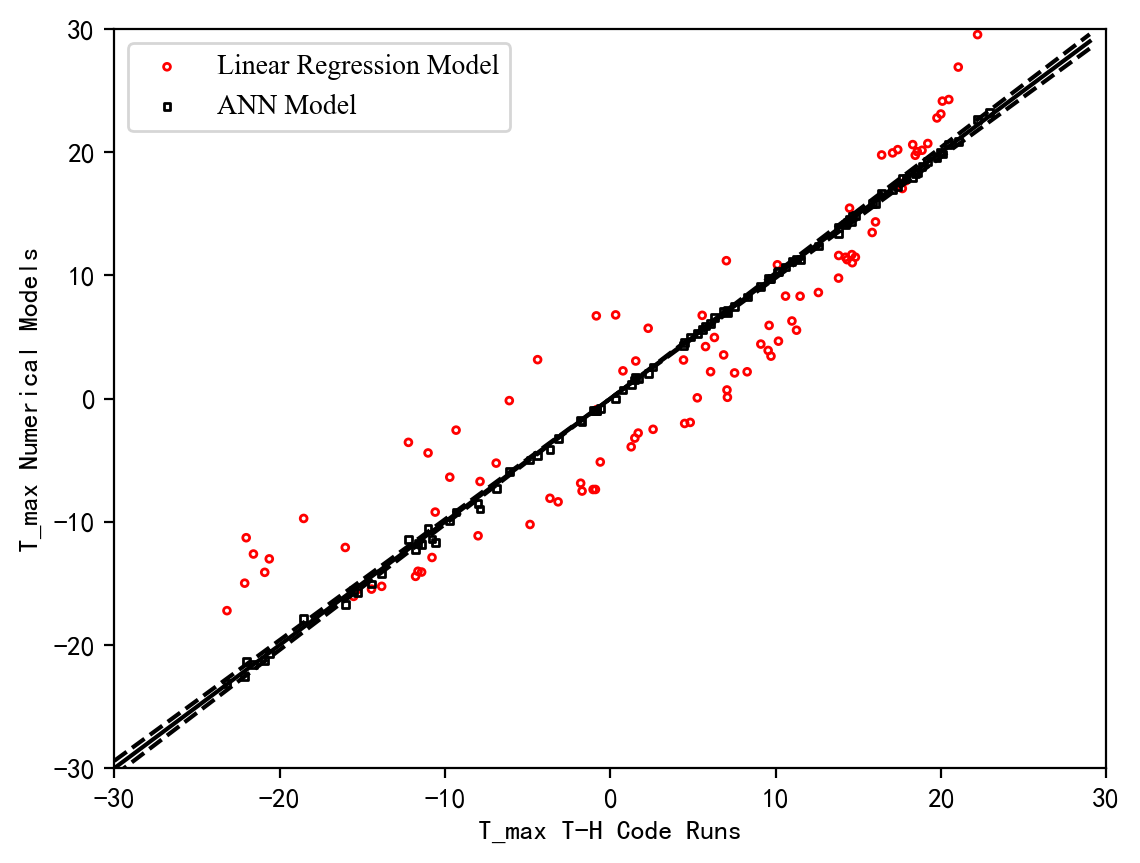

In [67]:
x_plt = np.arange(-30, 30, 1)
y_09 = 0.98*x_plt
y_11 = 1.02*x_plt
plt.figure(dpi = 200)
plt.scatter(z_data, z_LR, s=6, marker='o', c='none', edgecolors='r', label='Linear Regression Model')
plt.scatter(z_data, z_ANN, s=6, marker='s', c='none', edgecolors='k', label='ANN Model')
# plt.scatter(y_t, z_ANN, s=6, marker='^', c='none', edgecolors='b', label='ANN Model')
plt.plot(x_plt, y_09, c='k', linestyle='--')
plt.plot(x_plt, y_11, c='k', linestyle='--')
plt.plot(x_plt, x_plt, c='k')
font = {'family': 'Times New Roman'}
plt.legend(prop = font)
plt.xlabel('T_max T-H Code Runs')
plt.ylabel('T_max Numerical Models')
plt.xlim(-30, 30)
plt.ylim(-30, 30)
plt.show()

In [3]:
def ANN(u, model, x, y):
    x1_ANN = (2 * u[:, 0] - max(x[:, 0]) - min(x[:, 0])) / (max(x[:, 0]) - min(x[:, 0]))
    x2_ANN = (2 * u[:, 1] - max(x[:, 1]) - min(x[:, 1])) / (max(x[:, 1]) - min(x[:, 1]))
    x_ANN = np.hstack((x1_ANN.astype('float32').reshape(-1,1), x2_ANN.astype('float32').reshape(-1,1)))

    y_ANN = model.predict(x_ANN)
    y_output = (y_ANN * (max(y) - min(y)) + max(y) + min(y)) / 2
    # print(y_output.shape)
    # print('111')
    return(y_output)

In [278]:
time_start = time.time()

P_res_1 = np.zeros(10)
for i in range(10):
    N = 50000
    d = 2
    random_seed = latin_hypercube(N, d)

    x1_tt = truncnorm.ppf(random_seed[:, 0], a = -2, b = 2, loc = 1, scale = 0.49)
    x2_tt = truncnorm.ppf(random_seed[:, 1], a = -2, b = 2, loc = 1, scale = 0.49)
    x_tt = np.hstack((x1_tt.reshape(-1,1), x2_tt.reshape(-1,1)))

    y_ANN = ANN(x_tt, model2, x, y)

    for j in range(N):
        if y_ANN[j] < 0:
            P_res_1[i] = P_res_1[i] + 1/N
    print(i)
P_res_1
time_end = time.time()
time_CPU_1 = time_end - time_start

0
1
2
3
4
5
6
7
8
9


In [279]:
np.mean(P_res_1), np.var(P_res_1), min(P_res_1), max(P_res_1), time_CPU_1

(0.000378, 4.116e-09, 0.00022, 0.00044, 7.27070426940918)

In [ ]:
# 方法2：一般重要抽样

In [245]:
time_start = time.time()
P_res_2 = np.zeros(10)
for k in range(10):
    n = 100
    d = 2
    P_f = 0
    random_seed = latin_hypercube(n, d)

    x1_rvs = truncexpon.ppf(random_seed[:, 0], b = 1.96/2, loc = 0.02, scale = 2)
    x2_rvs = truncexpon.ppf(random_seed[:, 1], b = 1.96/2, loc = 0.02, scale = 2)
    x_rvs = np.hstack((x1_rvs.reshape(-1,1), x2_rvs.reshape(-1,1)))

    y_rvs = 440 - RELAP5(x_rvs)

    f_p = 0
    w1 = truncnorm.pdf(x1_rvs, a = -2, b = 2, loc = 1, scale = 0.49) / truncexpon.pdf(x1_rvs, b = 1.96/2, loc = 0.02, scale = 2)
    w2 = truncnorm.pdf(x2_rvs, a = -2, b = 2, loc = 1, scale = 0.49) / truncexpon.pdf(x2_rvs, b = 1.96/2, loc = 0.02, scale = 2)
    for i in range(n):
        if y_rvs[i] < 0:
            f_p = f_p + w1[i] * w2[i]
    P_res_2[k] = f_p / n
    print(k)
time_end = time.time()
time_CPU_2 = time_end - time_start

N = 100
D:\copydir\testNo.0 already exist!
D:\copydir\testNo.1 already exist!
D:\copydir\testNo.2 already exist!
D:\copydir\testNo.3 already exist!
D:\copydir\testNo.4 already exist!
D:\copydir\testNo.5 already exist!
D:\copydir\testNo.6 already exist!
D:\copydir\testNo.7 already exist!
D:\copydir\testNo.8 already exist!
D:\copydir\testNo.9 already exist!
D:\copydir\testNo.10 already exist!
D:\copydir\testNo.11 already exist!
D:\copydir\testNo.12 already exist!
D:\copydir\testNo.13 already exist!
D:\copydir\testNo.14 already exist!
D:\copydir\testNo.15 already exist!
D:\copydir\testNo.16 already exist!
D:\copydir\testNo.17 already exist!
D:\copydir\testNo.18 already exist!
D:\copydir\testNo.19 already exist!
D:\copydir\testNo.20 already exist!
D:\copydir\testNo.21 already exist!
D:\copydir\testNo.22 already exist!
D:\copydir\testNo.23 already exist!
D:\copydir\testNo.24 already exist!
D:\copydir\testNo.25 already exist!
D:\copydir\testNo.26 already exist!
D:\copydir\testNo.27 already e

D:\copydir\testNo.48 already exist!
D:\copydir\testNo.49 already exist!
D:\copydir\testNo.50 already exist!
D:\copydir\testNo.51 already exist!
D:\copydir\testNo.52 already exist!
D:\copydir\testNo.53 already exist!
D:\copydir\testNo.54 already exist!
D:\copydir\testNo.55 already exist!
D:\copydir\testNo.56 already exist!
D:\copydir\testNo.57 already exist!
D:\copydir\testNo.58 already exist!
D:\copydir\testNo.59 already exist!
D:\copydir\testNo.60 already exist!
D:\copydir\testNo.61 already exist!
D:\copydir\testNo.62 already exist!
D:\copydir\testNo.63 already exist!
D:\copydir\testNo.64 already exist!
D:\copydir\testNo.65 already exist!
D:\copydir\testNo.66 already exist!
D:\copydir\testNo.67 already exist!
D:\copydir\testNo.68 already exist!
D:\copydir\testNo.69 already exist!
D:\copydir\testNo.70 already exist!
D:\copydir\testNo.71 already exist!
D:\copydir\testNo.72 already exist!
D:\copydir\testNo.73 already exist!
D:\copydir\testNo.74 already exist!
D:\copydir\testNo.75 already

D:\copydir\testNo.80 already exist!
D:\copydir\testNo.81 already exist!
D:\copydir\testNo.82 already exist!
D:\copydir\testNo.83 already exist!
D:\copydir\testNo.84 already exist!
D:\copydir\testNo.85 already exist!
D:\copydir\testNo.86 already exist!
D:\copydir\testNo.87 already exist!
D:\copydir\testNo.88 already exist!
D:\copydir\testNo.89 already exist!
D:\copydir\testNo.90 already exist!
D:\copydir\testNo.91 already exist!
D:\copydir\testNo.92 already exist!
D:\copydir\testNo.93 already exist!
D:\copydir\testNo.94 already exist!
D:\copydir\testNo.95 already exist!
D:\copydir\testNo.96 already exist!
D:\copydir\testNo.97 already exist!
D:\copydir\testNo.98 already exist!
D:\copydir\testNo.99 already exist!
4
N = 100
D:\copydir\testNo.0 already exist!
D:\copydir\testNo.1 already exist!
D:\copydir\testNo.2 already exist!
D:\copydir\testNo.3 already exist!
D:\copydir\testNo.4 already exist!
D:\copydir\testNo.5 already exist!
D:\copydir\testNo.6 already exist!
D:\copydir\testNo.7 alrea

D:\copydir\testNo.26 already exist!
D:\copydir\testNo.27 already exist!
D:\copydir\testNo.28 already exist!
D:\copydir\testNo.29 already exist!
D:\copydir\testNo.30 already exist!
D:\copydir\testNo.31 already exist!
D:\copydir\testNo.32 already exist!
D:\copydir\testNo.33 already exist!
D:\copydir\testNo.34 already exist!
D:\copydir\testNo.35 already exist!
D:\copydir\testNo.36 already exist!
D:\copydir\testNo.37 already exist!
D:\copydir\testNo.38 already exist!
D:\copydir\testNo.39 already exist!
D:\copydir\testNo.40 already exist!
D:\copydir\testNo.41 already exist!
D:\copydir\testNo.42 already exist!
D:\copydir\testNo.43 already exist!
D:\copydir\testNo.44 already exist!
D:\copydir\testNo.45 already exist!
D:\copydir\testNo.46 already exist!
D:\copydir\testNo.47 already exist!
D:\copydir\testNo.48 already exist!
D:\copydir\testNo.49 already exist!
D:\copydir\testNo.50 already exist!
D:\copydir\testNo.51 already exist!
D:\copydir\testNo.52 already exist!
D:\copydir\testNo.53 already

D:\copydir\testNo.81 already exist!
D:\copydir\testNo.82 already exist!
D:\copydir\testNo.83 already exist!
D:\copydir\testNo.84 already exist!
D:\copydir\testNo.85 already exist!
D:\copydir\testNo.86 already exist!
D:\copydir\testNo.87 already exist!
D:\copydir\testNo.88 already exist!
D:\copydir\testNo.89 already exist!
D:\copydir\testNo.90 already exist!
D:\copydir\testNo.91 already exist!
D:\copydir\testNo.92 already exist!
D:\copydir\testNo.93 already exist!
D:\copydir\testNo.94 already exist!
D:\copydir\testNo.95 already exist!
D:\copydir\testNo.96 already exist!
D:\copydir\testNo.97 already exist!
D:\copydir\testNo.98 already exist!
D:\copydir\testNo.99 already exist!
9


In [246]:
np.mean(P_res_2), np.var(P_res_2), min(P_res_2), max(P_res_2), time_CPU_2

(0.0005760589268394324,
 1.8037362144424917e-07,
 0.0,
 0.0012741252319967938,
 3704.4742209911346)

In [ ]:
# 方法3：AM-SIS方法

In [4]:
# 二分法找零点，计算条件失效概率
def binary_search(f, a, b, epsilon):
    while abs(b - a) > epsilon:
        c = (a + b) / 2
        if f(c) == 0:
            return c
        elif f(a) * f(c) < 0:
            b = c
        else:
            a = c
    return (a + b) / 2

In [108]:
"""
---------------------------------------------------------------------------
Subset Simulation: 简单自然循环回路案例: y = 440 - RELAP5(u)
---------------------------------------------------------------------------
"""

# time_start = time.time()
# %% definition of the random variables
d      = 2          # number of dimensions
pi_pdf = list()
for i in range(d):
    pi_pdf.append(ERADist('truncatednormal','PAR',[1, 0.49, 0.02, 1.98])) # n independent rv

# correlation matrix
R = np.eye(d)   # independent case

# object with distribution information
pi_pdf = ERANataf(pi_pdf, R)    # if you want to include dependence

# %% limit state function
# g = lambda u: f(u)

# 导入神经网络模型
path = r'D:\relap5-2\TEST\model\TEST_1L10P_2_100.h5'
model = keras.models.load_model(path)

# 导入用于归一化的x和y
filepath = r'C:\Users\JH\Desktop\T_max test 100(expon).csv'
df = pd.read_csv(filepath)
data = df.values
x1 = data[:,0].astype('float32').reshape(-1,1)
x2 = data[:,1].astype('float32').reshape(-1,1)
x = np.hstack((x1, x2))
y = data[:,2].astype('float32').reshape(-1,1)

# g = ANN(u, model, x, y)


# %% subset simulation
for k in range(1):
    N  = 1000      # Total number of samples for each level
    # N  = 100000        # Total number of samples for each level
    p0 = 0.1         # Probability of each subset, chosen adaptively

    # Implementation of sensitivity analysis: 1 - perform, 0 - not perform
    sensitivity_analysis = 0

    # Samples return: 0 - none, 1 - final sample, 2 - all samples
    samples_return = 1

    print('\n\nSUBSET SIMULATION: ')
    [Pf_SuS, delta_SuS, b, Pf, b_sus, pf_sus, samplesU, samplesX, S_F1] = SuS(N, p0, ANN, pi_pdf, sensitivity_analysis, samples_return, model, x, y)

    # Reference values
    # The reference values for the first order indices
    S_F1_ref   = [0.0003, 0.0005]  # 这里是蒙卡结果

    # Print reference values for the first order indices
    print("\n***Reference first order Sobol' indices: ***\n", S_F1_ref)

    # # exact solution
    # pf_ex    = sp.stats.norm.cdf(-beta)
    # Pf_exact = lambda gg: sp.stats.norm.cdf(gg,beta,1)
    # gg       = np.linspace(0,7,140)

    # show p_f results
    # print('\n***Exact Pf: ', pf_ex, ' ***')
    print('***SuS Pf: ', Pf_SuS, ' ***\n')

    X = np.array(samplesX).ravel().reshape(-1,2)

    y_ANN = ANN(X, model, x, y)

    output = np.hstack((X, y_ANN))
    res = output[np.argsort(-output[:, 2])]        #对输出值降序排列（带负号就是降序）
    header = ['x1', 'x2', 'y_ANN']
    TargetFile = r'C:\Users\JH\Desktop\test_extra(ANN).csv'
    df = pd.DataFrame(res).drop_duplicates()       #去除重复行
    df.to_csv(TargetFile, header = header, index = None)
res_0 = Pf_SuS
res_0



SUBSET SIMULATION: 
Evaluating performance function:	OK!

-Threshold intermediate level  0  =  61.74330749511719
	*aCS lambda = 0.7365222284740937 	*aCS sigma = 0.7365222284740937 	*aCS accrate = 0.46419753086419757

-Threshold intermediate level  1  =  10.103010177612305
	*aCS lambda = 0.3313445349283285 	*aCS sigma = 0.3313445349283285 	*aCS accrate = 0.31565656565656564

-Threshold intermediate level  2  =  4.564172744750977
	*aCS lambda = 0.39496970274993076 	*aCS sigma = 0.39496970274993076 	*aCS accrate = 0.4703282828282828

-Threshold intermediate level  3  =  0.0
	*aCS lambda = 0.375850570262376 	*aCS sigma = 0.375850570262376 	*aCS accrate = 0.4411764705882353

***Reference first order Sobol' indices: ***
 [0.0003, 0.0005]
***SuS Pf:  0.0006740000000000002  ***



In [110]:
filepath = r'C:\Users\JH\Desktop\test_extra(ANN).csv'
df = pd.read_csv(filepath)
data = df.values[:30,:]

X30 = data[:, 0:2]
y30 = 440 - RELAP5(X30)
output = np.hstack((X30, y30.reshape(-1,1)))
header = ['x1', 'x2', 'y']
TargetFile = r'C:\Users\JH\Desktop\test_1-30(extra).csv'
pd.DataFrame(output).to_csv(TargetFile, header = header, index = None)

N = 30
D:\copydir\testNo.0 already exist!
D:\copydir\testNo.1 already exist!
D:\copydir\testNo.2 already exist!
D:\copydir\testNo.3 already exist!
D:\copydir\testNo.4 already exist!
D:\copydir\testNo.5 already exist!
D:\copydir\testNo.6 already exist!
D:\copydir\testNo.7 already exist!
D:\copydir\testNo.8 already exist!
D:\copydir\testNo.9 already exist!
D:\copydir\testNo.10 already exist!
D:\copydir\testNo.11 already exist!
D:\copydir\testNo.12 already exist!
D:\copydir\testNo.13 already exist!
D:\copydir\testNo.14 already exist!
D:\copydir\testNo.15 already exist!
D:\copydir\testNo.16 already exist!
D:\copydir\testNo.17 already exist!
D:\copydir\testNo.18 already exist!
D:\copydir\testNo.19 already exist!
D:\copydir\testNo.20 already exist!
D:\copydir\testNo.21 already exist!
D:\copydir\testNo.22 already exist!
D:\copydir\testNo.23 already exist!
D:\copydir\testNo.24 already exist!
D:\copydir\testNo.25 already exist!
D:\copydir\testNo.26 already exist!
D:\copydir\testNo.27 already ex

In [125]:
# 迭代开始
filepath = r'C:\Users\JH\Desktop\test_1-30(extra8).csv'
df_extra = pd.read_csv(filepath)
filepath = r'C:\Users\JH\Desktop\test_380(total).csv'
df = pd.read_csv(filepath)
data_extra = df_extra.values
data = df.values
data_total = np.vstack((data_extra, data))

header = ['x1', 'x2', 'y_ANN']
TargetFile = r'C:\Users\JH\Desktop\test_410(total).csv'
pd.DataFrame(data_total).to_csv(TargetFile, header = header, index = None)
data_total.shape, data_total

((410, 3),
 array([[ 0.28117814,  0.03229396,  0.1108    ],
        [ 0.37366211,  0.02141   , -2.747     ],
        [ 0.37888692,  0.02048546, -3.4678    ],
        ...,
        [ 0.12050813,  0.21108222, 17.3909    ],
        [ 0.18028573,  0.14789866, 17.6658    ],
        [ 0.19370458,  0.10886917, 14.6144    ]]))

In [205]:
filepath = r'C:\Users\JH\Desktop\test_410(total).csv'
df = pd.read_csv(filepath)
data_total = df.values

In [168]:
# 极值配置

x1 = (0.02, 1.98)
x2 = (0.02, 1.98)
# x3 = (0.02, 1.98)
[X, Y] = np.meshgrid(x1, x2)
xnod = np.vstack([X.T.ravel(), Y.T.ravel()]).T
xnod

array([[0.02, 0.02],
       [0.02, 1.98],
       [1.98, 0.02],
       [1.98, 1.98]])

In [170]:
ynod = 440 - RELAP5(xnod)

N = 4
D:\copydir\testNo.0 already exist!
D:\copydir\testNo.1 already exist!
D:\copydir\testNo.2 already exist!
D:\copydir\testNo.3 already exist!


In [206]:
data_nod = np.hstack((xnod, ynod))

total_size = len(data_total)
train_size = round(total_size * 0.8)
test_size = round(total_size * 0.2)
pred_size = 0
N = np.arange(total_size)
np.random.shuffle(N)
N, total_size, data_nod

(array([307, 216, 367, 280,  81, 102, 209,  25,  44, 111, 390, 357, 279,
        233, 301,  87, 117, 174, 119, 355, 305,  40, 222,  30, 133, 284,
        393, 340, 372, 297, 144, 162, 304, 152, 173, 170,  39, 312, 207,
        267, 346, 286, 234, 219, 278, 153, 291, 212,  17, 217,  38, 193,
        160, 282,  55, 383, 168, 306, 141, 401, 409,  57, 108,  93,  64,
        180, 327,  20, 254, 194, 302, 344, 110, 191, 293, 336, 283, 120,
        265, 316,   4, 397, 353, 262, 177, 200,   2, 402, 218, 364, 270,
        244, 127, 114,  41, 299,  96,  51, 184, 247, 349, 182, 404, 319,
        189, 195, 203, 136, 181,   9, 201,  92, 376, 237, 323, 378,  83,
        380, 149, 273, 227, 239, 329,  89, 343, 391, 205, 295,  50,  29,
        134, 192, 253, 406,  88, 342,  99, 210, 386,  45, 220, 190, 131,
         18, 348, 251,   7, 375, 132, 104, 116, 322, 107, 142,  21, 370,
        290, 229, 176, 339, 139, 334, 399,  22, 213, 118,  33, 347, 281,
         56, 130, 100, 405,  53, 238,  23, 161,  54

In [207]:
x1 = data_total[N,0].astype('float32').reshape(-1,1)
x2 = data_total[N,1].astype('float32').reshape(-1,1)
y = data_total[N,2].astype('float32').reshape(-1,1)

x1_extra = data_nod[:,0].astype('float32').reshape(-1,1)
x2_extra = data_nod[:,1].astype('float32').reshape(-1,1)
y_extra = data_nod[:,2].astype('float32').reshape(-1,1)

x1 = np.vstack((x1_extra, x1))
x2 = np.vstack((x2_extra, x2))
y = np.vstack((y_extra, y))
train_size = train_size + len(data_nod)  # 这里多次运算会出现重复叠加的错误
total_size = total_size + len(data_nod)  # 这里多次运算会出现重复叠加的错误

output = np.hstack((x1, x2, y))
header = ['x1', 'x2', 'y']
TargetFile = r'C:\Users\JH\Desktop\test_414(total).csv'
pd.DataFrame(output).to_csv(TargetFile, header = header, index = None)

In [177]:
x = np.hstack((x1, x2))
x, max(x[:,0]), min(x[:,0])

(array([[0.21249798, 0.03739659],
        [0.1702586 , 0.05016986],
        [0.02197454, 0.24792357],
        [0.3645156 , 0.02258552],
        [0.18593037, 0.04635796],
        [0.8004099 , 1.7749823 ],
        [0.04143867, 0.88109934],
        [0.16024716, 0.03659692],
        [0.03472735, 0.9822039 ],
        [0.03369268, 0.18777299],
        [0.15313117, 0.06470207],
        [0.11278544, 0.07589038],
        [0.0981634 , 0.08127809],
        [0.13039036, 0.06349489],
        [0.19370458, 0.10886917],
        [0.3959056 , 0.0219365 ],
        [0.35241222, 0.02681902],
        [0.39402103, 0.02112544],
        [0.05977546, 0.16711275],
        [0.235184  , 0.03296055],
        [0.6326247 , 1.5249033 ],
        [0.04303544, 0.7320547 ],
        [0.16262953, 0.07096688],
        [0.26456004, 0.03124791],
        [0.05269728, 0.2155944 ],
        [0.33957884, 0.02845219],
        [0.10433663, 0.08389598],
        [0.23051137, 0.03842753],
        [0.02955119, 0.21566056],
        [0.069

In [178]:
# 归一化到(-1,1)
x1_total = (2 * x1 - max(x1) - min(x1)) / (max(x1) - min(x1))
x2_total = (2 * x2 - max(x2) - min(x2)) / (max(x2) - min(x2))
y_total = (2 * y - max(y) - min(y)) / (max(y) - min(y))

In [179]:
x_total = np.hstack((x1_total, x2_total))
x_train = x_total[0:train_size,:]
x_train

array([[-8.03573489e-01, -9.82248366e-01],
       [-8.46674919e-01, -9.69214439e-01],
       [-9.97985125e-01, -7.67424941e-01],
       [-6.48453474e-01, -9.97361720e-01],
       [-8.30683291e-01, -9.73104060e-01],
       [-2.03663364e-01,  7.90798306e-01],
       [-9.78123784e-01, -1.21327206e-01],
       [-8.56890678e-01, -9.83064353e-01],
       [-9.84972060e-01, -1.81592945e-02],
       [-9.86027896e-01, -8.28803062e-01],
       [-8.64151835e-01, -9.54385579e-01],
       [-9.05320942e-01, -9.42969024e-01],
       [-9.20241356e-01, -9.37471330e-01],
       [-8.87356758e-01, -9.55617428e-01],
       [-8.22750390e-01, -9.09317136e-01],
       [-6.16422832e-01, -9.98023987e-01],
       [-6.60803854e-01, -9.93041754e-01],
       [-6.18345857e-01, -9.98851597e-01],
       [-9.59412754e-01, -8.49884927e-01],
       [-7.80424476e-01, -9.86774921e-01],
       [-3.74872774e-01,  5.35615623e-01],
       [-9.76494431e-01, -2.73413569e-01],
       [-8.54459643e-01, -9.47992921e-01],
       [-7.

In [180]:
# x_train = x_total[0:train_size,:]
x_test = x_total[train_size:train_size+test_size,:]
x_pred = x_total[train_size+test_size:total_size,:]
# x_pred = x_ex
y_train = y_total[0:train_size,:]
# y_train = y_total[0:train_size,:]
y_test = y_total[train_size:train_size+test_size,:]
y_pred = y_total[train_size+test_size:total_size,:]
# y_pred = y_ex

In [181]:
x_train.shape, y_train.shape

((332, 2), (332, 1))

In [182]:
model1 = Sequential()
# model1.add(Dense(units=100, input_dim=4, activation="tanh", kernel_regularizer='l2'))
model1.add(Dense(units=40, input_dim=2, activation="tanh"))
# model1.add(Dense(units=10, activation="tanh"))
# model1.add(Dense(units=10, activation="tanh"))
# model1.add(Dense(units=10, activation="tanh"))
model1.add(Dense(units=1, activation="linear"))
# model1.add(Dense(units=50, activation="relu"))
# model1.add(Dense(units=50, activation="relu"))
# model1.add(Dense(units=50, activation="relu"))
# model1.add(Dense(units=50, activation="relu"))
# model1.add(Dense(units=50, activation="relu"))
# model1.add(Dense(units=50, activation="relu"))
# model1.add(Dense(units=50, activation="relu"))
# model1.add(Dense(units=1, activation="linear"))

In [183]:
x_t = np.vstack((x_train, x_test))
y_t = np.vstack((y_train, y_test))
x_t.shape, y_t.shape

((414, 2), (414, 1))

In [184]:
def calculateMSE(X,Y):
    return sum([(y-x)**2 for x,y in zip(X,Y)])/len(X)

class stopAtLossValue(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        THR = 0.0000001
        if logs.get('loss') < THR:
            print("\n !!! enough small loss, no further training !!!")
            self.model.stop_training = True
end_train = stopAtLossValue()  

path = r'D:\relap5-2\TEST\model\keras_2_414.h5'
checkpoint = keras.callbacks.ModelCheckpoint(path, monitor='val_loss', save_best_only=True)

In [189]:
opm = tf.keras.optimizers.Adam(learning_rate=0.0001)
model1.compile(optimizer=opm,loss='mse')  
model1.summary()

#训练模型（batch_size默认为32）
history = model1.fit(x_train, y_train, batch_size = 8, validation_data = (x_test, y_test),
                     epochs = 10000, callbacks = [end_train, checkpoint])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 40)                120       
                                                                 
 dense_11 (Dense)            (None, 1)                 41        
                                                                 
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10000
42/42 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0039
Epoch 2/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 3/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 4/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 5/10000
42/42 [===========================

42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 75/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 76/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0044
Epoch 77/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 78/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 79/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0042
Epoch 80/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 81/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0048
Epoch 82/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 83/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.

Epoch 154/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 155/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 156/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 157/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 158/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 159/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 160/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 161/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 162/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 163/10000
42/42 [==============================] - 0s 1ms/step - lo

42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 234/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 235/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 236/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 237/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0042
Epoch 238/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 239/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 240/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 241/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 242/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val

42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0042
Epoch 313/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0041
Epoch 314/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0043
Epoch 315/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 316/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 317/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 318/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 319/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 320/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 321/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val

42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 392/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 393/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 394/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0047
Epoch 395/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0040
Epoch 396/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 397/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 398/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 399/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 400/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val

42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 471/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 472/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 473/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 474/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 475/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 476/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 477/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0044
Epoch 478/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 479/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val

42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 550/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 551/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 552/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 553/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 554/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 555/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 556/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 557/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 558/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val

42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 629/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 630/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 631/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 632/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 633/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 634/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 635/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 636/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0050
Epoch 637/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0022 - val

42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 708/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 709/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 710/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 711/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 712/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 713/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 714/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 715/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 716/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val

42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 787/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 788/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 789/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 790/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 791/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 792/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0042
Epoch 793/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 794/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 795/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val

42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 866/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0042
Epoch 867/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 868/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 869/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 870/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 871/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0046
Epoch 872/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 873/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 874/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val

42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 945/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0039
Epoch 946/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 947/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0044
Epoch 948/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0044
Epoch 949/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 950/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 951/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 952/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 953/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val

42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 1024/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 1025/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 1026/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 1027/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 1028/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 1029/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 1030/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0042
Epoch 1031/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 1032/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0

Epoch 1102/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 1103/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0041
Epoch 1104/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 1105/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 1106/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 1107/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0043
Epoch 1108/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 1109/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 1110/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 1111/10000
42/42 [==============================] - 0s 1ms

42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 1181/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 1182/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 1183/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 1184/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 1185/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0039
Epoch 1186/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 1187/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 1188/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 1189/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0

Epoch 1259/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 1260/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 1261/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0042
Epoch 1262/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 1263/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 1264/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 1265/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 1266/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 1267/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 1268/10000
42/42 [==============================] - 0s 1ms

Epoch 1338/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 1339/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 1340/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 1341/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 1342/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 1343/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 1344/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 1345/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 1346/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 1347/10000
42/42 [==============================] - 0s 1ms

Epoch 1417/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 1418/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0042
Epoch 1419/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 1420/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 1421/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 1422/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 1423/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 1424/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 1425/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 1426/10000
42/42 [==============================] - 0s 1ms

42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0039
Epoch 1496/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 1497/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 1498/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 1499/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 1500/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 1501/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 1502/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 1503/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 1504/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0

Epoch 1574/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 1575/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 1576/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0044
Epoch 1577/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 1578/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 1579/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 1580/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 1581/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 1582/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 1583/10000
42/42 [==============================] - 0s 1ms

Epoch 1653/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 1654/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 1655/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 1656/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0041
Epoch 1657/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 1658/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0041
Epoch 1659/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 1660/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 1661/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 1662/10000
42/42 [==============================] - 0s 1ms

Epoch 1732/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0041
Epoch 1733/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0039
Epoch 1734/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 1735/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 1736/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 1737/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 1738/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0042
Epoch 1739/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 1740/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 1741/10000
42/42 [==============================] - 0s 1ms

Epoch 1811/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0042
Epoch 1812/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0041
Epoch 1813/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 1814/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 1815/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 1816/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0042
Epoch 1817/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 1818/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 1819/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 1820/10000
42/42 [==============================] - 0s 1ms

Epoch 1890/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 1891/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 1892/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 1893/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 1894/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 1895/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 1896/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 1897/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 1898/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 1899/10000
42/42 [==============================] - 0s 1ms

Epoch 1969/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 1970/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 1971/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 1972/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0039
Epoch 1973/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0044
Epoch 1974/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 1975/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 1976/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 1977/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 1978/10000
42/42 [==============================] - 0s 1ms

Epoch 2048/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 2049/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 2050/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 2051/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 2052/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0039
Epoch 2053/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 2054/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0039
Epoch 2055/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 2056/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 2057/10000
42/42 [==============================] - 0s 1ms

Epoch 2127/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 2128/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0041
Epoch 2129/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 2130/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 2131/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 2132/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 2133/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0041
Epoch 2134/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 2135/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 2136/10000
42/42 [==============================] - 0s 1ms

Epoch 2206/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 2207/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 2208/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 2209/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 2210/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 2211/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 2212/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 2213/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0039
Epoch 2214/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 2215/10000
42/42 [==============================] - 0s 1ms

Epoch 2285/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 2286/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 2287/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0039
Epoch 2288/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 2289/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 2290/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 2291/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 2292/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 2293/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 2294/10000
42/42 [==============================] - 0s 1ms

Epoch 2364/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 2365/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 2366/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 2367/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 2368/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 2369/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 2370/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 2371/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 2372/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 2373/10000
42/42 [==============================] - 0s 1ms

Epoch 2443/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 2444/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 2445/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 2446/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0039
Epoch 2447/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 2448/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 2449/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 2450/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 2451/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 2452/10000
42/42 [==============================] - 0s 1ms

42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0039
Epoch 2522/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0044
Epoch 2523/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 2524/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0043
Epoch 2525/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0042
Epoch 2526/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 2527/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 2528/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0041
Epoch 2529/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 2530/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0

Epoch 2600/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 2601/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 2602/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 2603/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 2604/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0039
Epoch 2605/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 2606/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 2607/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 2608/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 2609/10000
42/42 [==============================] - 0s 1ms

Epoch 2679/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0039
Epoch 2680/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 2681/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 2682/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 2683/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0043
Epoch 2684/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0040
Epoch 2685/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 2686/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 2687/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 2688/10000
42/42 [==============================] - 0s 1ms

Epoch 2758/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 2759/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0043
Epoch 2760/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 2761/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 2762/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 2763/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 2764/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 2765/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 2766/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 2767/10000
42/42 [==============================] - 0s 1ms

42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 2837/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 2838/10000
42/42 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 2839/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 2840/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 2841/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 2842/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 2843/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 2844/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 2845/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0

Epoch 2915/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 2916/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 2917/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 2918/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0041
Epoch 2919/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 2920/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 2921/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 2922/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 2923/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 2924/10000
42/42 [==============================] - 0s 1ms

42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 2994/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 2995/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 2996/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 2997/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 2998/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 2999/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3000/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3001/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 3002/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0

Epoch 3072/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 3073/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0039
Epoch 3074/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3075/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0041
Epoch 3076/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 3077/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 3078/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0042
Epoch 3079/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0039
Epoch 3080/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3081/10000
42/42 [==============================] - 0s 1ms

Epoch 3151/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 3152/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3153/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 3154/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 3155/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0039
Epoch 3156/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3157/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0040
Epoch 3158/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0039
Epoch 3159/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 3160/10000
42/42 [==============================] - 0s 1ms

Epoch 3230/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0039
Epoch 3231/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3232/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0039
Epoch 3233/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3234/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 3235/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 3236/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3237/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0041
Epoch 3238/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3239/10000
42/42 [==============================] - 0s 1ms

Epoch 3309/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3310/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 3311/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 3312/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 3313/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3314/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 3315/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3316/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 3317/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3318/10000
42/42 [==============================] - 0s 1ms

Epoch 3388/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0043
Epoch 3389/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3390/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3391/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 3392/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3393/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 3394/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3395/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3396/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 3397/10000
42/42 [==============================] - 0s 1ms

Epoch 3467/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3468/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 3469/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 3470/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3471/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 3472/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 3473/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3474/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3475/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3476/10000
42/42 [==============================] - 0s 1ms

Epoch 3546/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 3547/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3548/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3549/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 3550/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 3551/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 3552/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3553/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 3554/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 3555/10000
42/42 [==============================] - 0s 1ms

42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3625/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3626/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 3627/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3628/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 3629/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3630/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 3631/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 3632/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 3633/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0

Epoch 3703/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 3704/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 3705/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 3706/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 3707/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3708/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3709/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0039
Epoch 3710/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3711/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3712/10000
42/42 [==============================] - 0s 1ms

42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3782/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 3783/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3784/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3785/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0039
Epoch 3786/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3787/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 3788/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 3789/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3790/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0

Epoch 3860/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 3861/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3862/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3863/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 3864/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3865/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 3866/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3867/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 3868/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3869/10000
42/42 [==============================] - 0s 1ms

Epoch 3939/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 3940/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 3941/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3942/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3943/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3944/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3945/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 3946/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 3947/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0043
Epoch 3948/10000
42/42 [==============================] - 0s 1ms

42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0039
Epoch 4018/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 4019/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 4020/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 4021/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 4022/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 4023/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 4024/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 4025/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 4026/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0

Epoch 4096/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 4097/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 4098/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 4099/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 4100/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 4101/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 4102/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 4103/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 4104/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 4105/10000
42/42 [==============================] - 0s 1ms

Epoch 4175/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 4176/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 4177/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 4178/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 4179/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 4180/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 4181/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 4182/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 4183/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 4184/10000
42/42 [==============================] - 0s 1ms

42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 4254/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 4255/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 4256/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 4257/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0042
Epoch 4258/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 4259/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 4260/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 4261/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 4262/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0

Epoch 4332/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 4333/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 4334/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 4335/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 4336/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0043
Epoch 4337/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 4338/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0042
Epoch 4339/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 4340/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 4341/10000
42/42 [==============================] - 0s 1ms

42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 4411/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 4412/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 4413/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 4414/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 4415/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 4416/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 4417/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 4418/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0039
Epoch 4419/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0

Epoch 4489/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 4490/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 4491/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 4492/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 4493/10000
42/42 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 4494/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 4495/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 4496/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 4497/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 4498/10000
42/42 [==============================] - 0s 1ms

42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 4568/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 4569/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 4570/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 4571/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 4572/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 4573/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 4574/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 4575/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 4576/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0

Epoch 4646/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0043
Epoch 4647/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 4648/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 4649/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 4650/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 4651/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0039
Epoch 4652/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 4653/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 4654/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0042
Epoch 4655/10000
42/42 [==============================] - 0s 1ms

42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 4725/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0038
Epoch 4726/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 4727/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 4728/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 4729/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 4730/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 4731/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 4732/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0039
Epoch 4733/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0

Epoch 4803/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0038
Epoch 4804/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 4805/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 4806/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 4807/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 4808/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 4809/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 4810/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0042
Epoch 4811/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 4812/10000
42/42 [==============================] - 0s 1ms

42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 4882/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 4883/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 4884/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 4885/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 4886/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 4887/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 4888/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0039
Epoch 4889/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 4890/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0

Epoch 4960/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 4961/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 4962/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 4963/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 4964/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 4965/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 4966/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 4967/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 4968/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 4969/10000
42/42 [==============================] - 0s 1ms

Epoch 5039/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 5040/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 5041/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 5042/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 5043/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 5044/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 5045/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 5046/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 5047/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 5048/10000
42/42 [==============================] - 0s 1ms

Epoch 5118/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 5119/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 5120/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 5121/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 5122/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 5123/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 5124/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 5125/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 5126/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 5127/10000
42/42 [==============================] - 0s 1ms

42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 5197/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 5198/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 5199/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 5200/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 5201/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0043
Epoch 5202/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 5203/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 5204/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 5205/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0

Epoch 5275/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 5276/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 5277/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 5278/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 5279/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 5280/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0039
Epoch 5281/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 5282/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 5283/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 5284/10000
42/42 [==============================] - 0s 1ms

42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 5354/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 5355/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 5356/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 5357/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 5358/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 5359/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 5360/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 5361/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 5362/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0

Epoch 5432/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 5433/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 5434/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 5435/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 5436/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 5437/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 5438/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 5439/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 5440/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 5441/10000
42/42 [==============================] - 0s 1ms

42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 5511/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0039
Epoch 5512/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 5513/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 5514/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0038
Epoch 5515/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 5516/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 5517/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 5518/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 5519/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0

Epoch 5589/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 5590/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 5591/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 5592/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 5593/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 5594/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 5595/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 5596/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 5597/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0042
Epoch 5598/10000
42/42 [==============================] - 0s 1ms

Epoch 5668/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 5669/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 5670/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 5671/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 5672/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 5673/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 5674/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 5675/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 5676/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 5677/10000
42/42 [==============================] - 0s 1ms

Epoch 5747/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 5748/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 5749/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 5750/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 5751/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 5752/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 5753/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 5754/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0042
Epoch 5755/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 5756/10000
42/42 [==============================] - 0s 1ms

42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 5826/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 5827/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 5828/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 5829/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 5830/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 5831/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 5832/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 5833/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 5834/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0

Epoch 5904/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 5905/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 5906/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 5907/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 5908/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 5909/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 5910/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 5911/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 5912/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 5913/10000
42/42 [==============================] - 0s 1ms

Epoch 5983/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 5984/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 5985/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 5986/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0042
Epoch 5987/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 5988/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 5989/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 5990/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 5991/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 5992/10000
42/42 [==============================] - 0s 1ms

Epoch 6062/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 6063/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 6064/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 6065/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 6066/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 6067/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 6068/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0042
Epoch 6069/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 6070/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 6071/10000
42/42 [==============================] - 0s 1ms

Epoch 6141/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 6142/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 6143/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 6144/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 6145/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 6146/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 6147/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 6148/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 6149/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 6150/10000
42/42 [==============================] - 0s 1ms

42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 6220/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 6221/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 6222/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 6223/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 6224/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0038
Epoch 6225/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 6226/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 6227/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 6228/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0

Epoch 6298/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 6299/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 6300/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 6301/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 6302/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 6303/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 6304/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 6305/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 6306/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 6307/10000
42/42 [==============================] - 0s 1ms

42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0038
Epoch 6377/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 6378/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 6379/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0038
Epoch 6380/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 6381/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 6382/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 6383/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0042
Epoch 6384/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 6385/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0

Epoch 6455/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 6456/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0039
Epoch 6457/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 6458/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 6459/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 6460/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 6461/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 6462/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 6463/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 6464/10000
42/42 [==============================] - 0s 1ms

Epoch 6534/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 6535/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 6536/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 6537/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 6538/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 6539/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 6540/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 6541/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 6542/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 6543/10000
42/42 [==============================] - 0s 1ms

Epoch 6613/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 6614/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 6615/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 6616/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0041
Epoch 6617/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 6618/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 6619/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 6620/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 6621/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 6622/10000
42/42 [==============================] - 0s 1ms

42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 6692/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 6693/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 6694/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 6695/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 6696/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 6697/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 6698/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0043
Epoch 6699/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0043
Epoch 6700/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0

Epoch 6770/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0038
Epoch 6771/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 6772/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 6773/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 6774/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 6775/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 6776/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 6777/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0043
Epoch 6778/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 6779/10000
42/42 [==============================] - 0s 1ms

Epoch 6849/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0047
Epoch 6850/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0038
Epoch 6851/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 6852/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 6853/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 6854/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 6855/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 6856/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 6857/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 6858/10000
42/42 [==============================] - 0s 1ms

Epoch 6928/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 6929/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 6930/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 6931/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 6932/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 6933/10000
42/42 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 6934/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 6935/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 6936/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 6937/10000
42/42 [==============================] - 0s 1ms

42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7007/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7008/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7009/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0039
Epoch 7010/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7011/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7012/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 7013/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 7014/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7015/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0

Epoch 7085/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 7086/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7087/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 7088/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 7089/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7090/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 7091/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7092/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7093/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 7094/10000
42/42 [==============================] - 0s 1ms

Epoch 7164/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 7165/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 7166/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0042
Epoch 7167/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7168/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0044
Epoch 7169/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7170/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0038
Epoch 7171/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 7172/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7173/10000
42/42 [==============================] - 0s 1ms

42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7243/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7244/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7245/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 7246/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 7247/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7248/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7249/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 7250/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7251/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0

Epoch 7321/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 7322/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7323/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7324/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7325/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7326/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7327/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7328/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 7329/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7330/10000
42/42 [==============================] - 0s 1ms

Epoch 7400/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 7401/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0038
Epoch 7402/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 7403/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0045
Epoch 7404/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 7405/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 7406/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7407/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 7408/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0040
Epoch 7409/10000
42/42 [==============================] - 0s 1ms

Epoch 7479/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 7480/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7481/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 7482/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7483/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 7484/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0038
Epoch 7485/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7486/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 7487/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7488/10000
42/42 [==============================] - 0s 1ms

Epoch 7558/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7559/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 7560/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 7561/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 7562/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 7563/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 7564/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0043
Epoch 7565/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7566/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 7567/10000
42/42 [==============================] - 0s 1ms

42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7637/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 7638/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 7639/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7640/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 7641/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 7642/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7643/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 7644/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 7645/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0

Epoch 7715/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7716/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7717/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 7718/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 7719/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 7720/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7721/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7722/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7723/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 7724/10000
42/42 [==============================] - 0s 1ms

Epoch 7794/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7795/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7796/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 7797/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7798/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7799/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7800/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0038
Epoch 7801/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0038
Epoch 7802/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7803/10000
42/42 [==============================] - 0s 1ms

Epoch 7873/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 7874/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7875/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7876/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7877/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7878/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7879/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7880/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 7881/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 7882/10000
42/42 [==============================] - 0s 1ms

Epoch 7952/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0049
Epoch 7953/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 7954/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 7955/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7956/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7957/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 7958/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 7959/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 7960/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 7961/10000
42/42 [==============================] - 0s 1ms

42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 8031/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0043
Epoch 8032/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8033/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 8034/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 8035/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0042
Epoch 8036/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 8037/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 8038/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8039/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0

Epoch 8109/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8110/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8111/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0044
Epoch 8112/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8113/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 8114/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 8115/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 8116/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 8117/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8118/10000
42/42 [==============================] - 0s 1ms

Epoch 8188/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8189/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0038
Epoch 8190/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 8191/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0043
Epoch 8192/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8193/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 8194/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8195/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 8196/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0038
Epoch 8197/10000
42/42 [==============================] - 0s 1ms

Epoch 8267/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8268/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0044
Epoch 8269/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8270/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8271/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 8272/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8273/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8274/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8275/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 8276/10000
42/42 [==============================] - 0s 1ms

42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 8346/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0038
Epoch 8347/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 8348/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8349/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8350/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8351/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8352/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 8353/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 8354/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0

Epoch 8424/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 8425/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8426/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0041
Epoch 8427/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8428/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 8429/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8430/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0042
Epoch 8431/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0042
Epoch 8432/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 8433/10000
42/42 [==============================] - 0s 1ms

Epoch 8503/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8504/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8505/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8506/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 8507/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8508/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 8509/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0040
Epoch 8510/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 8511/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8512/10000
42/42 [==============================] - 0s 1ms

Epoch 8582/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0042
Epoch 8583/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8584/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 8585/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 8586/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8587/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8588/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8589/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8590/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0043
Epoch 8591/10000
42/42 [==============================] - 0s 1ms

Epoch 8661/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8662/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8663/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8664/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8665/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 8666/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 8667/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 8668/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8669/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 8670/10000
42/42 [==============================] - 0s 1ms

Epoch 8740/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0041
Epoch 8741/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 8742/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8743/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8744/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 8745/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8746/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 8747/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8748/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8749/10000
42/42 [==============================] - 0s 1ms

42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0042
Epoch 8819/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 8820/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8821/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 8822/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8823/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 8824/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 8825/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8826/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 8827/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0

Epoch 8897/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0039
Epoch 8898/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8899/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8900/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8901/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 8902/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 8903/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0043
Epoch 8904/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 8905/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8906/10000
42/42 [==============================] - 0s 1ms

Epoch 8976/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8977/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8978/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 8979/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8980/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0039
Epoch 8981/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 8982/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 8983/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 8984/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0040
Epoch 8985/10000
42/42 [==============================] - 0s 1ms

Epoch 9055/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0039
Epoch 9056/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 9057/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0038
Epoch 9058/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 9059/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 9060/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 9061/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 9062/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 9063/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 9064/10000
42/42 [==============================] - 0s 1ms

Epoch 9134/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 9135/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 9136/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0038
Epoch 9137/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 9138/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 9139/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 9140/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 9141/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0038
Epoch 9142/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0039
Epoch 9143/10000
42/42 [==============================] - 0s 1ms

42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 9213/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 9214/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0043
Epoch 9215/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 9216/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 9217/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 9218/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 9219/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 9220/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0042
Epoch 9221/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0

Epoch 9291/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 9292/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0042
Epoch 9293/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0039
Epoch 9294/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 9295/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 9296/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 9297/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 9298/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 9299/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 9300/10000
42/42 [==============================] - 0s 1ms

Epoch 9370/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 9371/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 9372/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 9373/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 9374/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 9375/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0041
Epoch 9376/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 9377/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 9378/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 9379/10000
42/42 [==============================] - 0s 1ms

Epoch 9449/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 9450/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 9451/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 9452/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 9453/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 9454/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 9455/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 9456/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0039
Epoch 9457/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 9458/10000
42/42 [==============================] - 0s 1ms

42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 9528/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 9529/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 9530/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0039
Epoch 9531/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 9532/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0042
Epoch 9533/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0042
Epoch 9534/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 9535/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 9536/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0

Epoch 9606/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 9607/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 9608/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0039
Epoch 9609/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 9610/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0039
Epoch 9611/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 9612/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0039
Epoch 9613/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 9614/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 9615/10000
42/42 [==============================] - 0s 1ms

Epoch 9685/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 9686/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 9687/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 9688/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 9689/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 9690/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0041
Epoch 9691/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 9692/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 9693/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 9694/10000
42/42 [==============================] - 0s 1ms

42/42 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0039
Epoch 9764/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0038
Epoch 9765/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 9766/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 9767/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 9768/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 9769/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 9770/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 9771/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 9772/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0

Epoch 9842/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0040
Epoch 9843/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 9844/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 9845/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 9846/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 9847/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 9848/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 9849/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 9850/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 9851/10000
42/42 [==============================] - 0s 1ms

42/42 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0043
Epoch 9921/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0049
Epoch 9922/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 9923/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 9924/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0038
Epoch 9925/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 9926/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 9927/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0038
Epoch 9928/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0042
Epoch 9929/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0

Epoch 9999/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 10000/10000
42/42 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0040


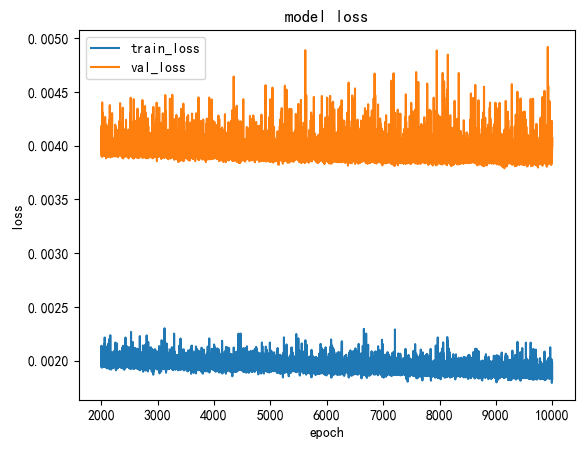

In [190]:
plt.plot(np.arange(2000,10000), history.history['loss'][2000:10000], label = 'train_loss')
plt.plot(np.arange(2000,10000), history.history['val_loss'][2000:10000], label = 'val_loss')
# plt.plot(history.history['loss'])
plt.title('model loss')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [191]:
np.hstack((y_test, model1.predict(x_test)))

array([[ 0.12251648,  0.2062372 ],
       [ 0.24960609,  0.24240124],
       [ 0.9036639 ,  0.8809205 ],
       [ 0.18875007,  0.17144191],
       [ 0.21543112,  0.20974171],
       [ 0.2491421 ,  0.24301136],
       [ 1.        ,  1.1443249 ],
       [ 0.2189728 ,  0.20498836],
       [ 0.21488701,  0.19270575],
       [ 0.8753605 ,  0.9555782 ],
       [ 0.23308608,  0.20501411],
       [ 0.1569351 ,  0.15421426],
       [ 0.64055526,  0.65691817],
       [ 0.2683559 ,  0.2406522 ],
       [ 1.        ,  1.0204912 ],
       [ 0.151681  ,  0.15640986],
       [ 0.90507585,  0.92341626],
       [ 0.15827031,  0.16739595],
       [ 0.943667  ,  0.9210788 ],
       [ 0.20024967,  0.20290577],
       [ 0.0831041 ,  0.11305916],
       [ 0.8800872 ,  0.8916279 ],
       [ 0.25721353,  0.24144328],
       [ 0.10915092,  0.13226473],
       [ 0.15160759,  0.2128669 ],
       [ 0.1619789 ,  0.17166483],
       [ 0.06922113,  0.11210048],
       [ 0.04515379,  0.08536434],
       [ 1.        ,

In [208]:
calculateMSE(y_test, model1.predict(x_test)),calculateMSE(y_train, model1.predict(x_train))

(array([0.00399329], dtype=float32), array([0.00206284], dtype=float32))

In [209]:
path = r'D:\relap5-2\TEST\model\keras_2_414.h5'
model2 = keras.models.load_model(path)
calculateMSE(y_test, model2.predict(x_test)),calculateMSE(y_train, model2.predict(x_train))

(array([0.0037492], dtype=float32), array([0.00213275], dtype=float32))

In [210]:
path = r'D:\relap5-2\TEST\model\test_1L40P_2_414.h5'
model2.save(path)
model2 = keras.models.load_model(path)
calculateMSE(y_test, model2.predict(x_test)),calculateMSE(y_train, model2.predict(x_train))
# model2.summary()

(array([0.0037492], dtype=float32), array([0.00213275], dtype=float32))

In [211]:
train_b = np.ones((train_size, 1))
train_xb = np.hstack((x_train, train_b))
train_xb

res = np.linalg.lstsq(train_xb, y_train, rcond=None)
res[0]

z1 = np.dot(train_xb, res[0])
z1

x_tp = np.vstack((x_train, x_pred))
y_tp = np.vstack((y_train, y_pred))
ANN_tp = model2.predict(x_tp)
tp_b = np.ones((train_size, 1))
tp_xb = np.hstack((x_tp, tp_b))
LR_tp = np.dot(tp_xb, res[0])
x_train

MSE_ANN = calculateMSE(ANN_tp, y_tp)
MSE_LR = calculateMSE(LR_tp, y_tp)
RMSE_ANN = np.sqrt(MSE_ANN)
RMSE_LR = np.sqrt(MSE_LR)
R2_ANN = 1 - MSE_ANN/np.var(y_tp)
R2_LR = 1 - MSE_LR/np.var(y_tp)
R2_LR, R2_ANN, RMSE_LR, RMSE_ANN

(array([0.46266859]),
 array([0.9835878], dtype=float32),
 array([0.26424548]),
 array([0.04618171], dtype=float32))

In [212]:
x_t = x_total
y_t = y_total
# y_total = (2 * y - max(y) - min(y)) / (max(y) - min(y))
z_data = (y_t * (max(y) - min(y)) + max(y) + min(y)) / 2
z_ANN = (model2.predict(x_t) * (max(y) - min(y)) + max(y) + min(y)) / 2
x_b = np.ones((total_size, 1))
x_tb = np.hstack((x_t, x_b))
z_LR = np.dot(x_tb, res[0])
z_LR = (z_LR * (max(y) - min(y)) + max(y) + min(y)) / 2
MSE_ANN = calculateMSE(z_ANN, z_data)
MSE_LR = calculateMSE(z_LR, z_data)
RMSE_ANN = np.sqrt(MSE_ANN)
RMSE_LR = np.sqrt(MSE_LR)
R2_ANN = 1 - MSE_ANN/np.var(z_data)
R2_LR = 1 - MSE_LR/np.var(z_data)
R2_LR, R2_ANN, RMSE_LR, RMSE_ANN

(array([0.44067865]),
 array([0.98204905], dtype=float32),
 array([8.28200292]),
 array([1.4837081], dtype=float32))

In [213]:
np.hstack((z_ANN, z_data)), MSE_ANN, np.var(z_data)

(array([[-1.78174019e+00, -2.34920025e+00],
        [-5.60073853e-01, -5.25499344e-01],
        [-2.82234478e+00, -3.66989994e+00],
        [-1.21448708e+00, -1.40089989e+00],
        [-4.45331573e-01, -4.97598648e-01],
        [ 2.14419651e+01,  2.33819981e+01],
        [ 1.98056812e+01,  2.16586018e+01],
        [-6.49252033e+00, -7.87459946e+00],
        [ 2.05487385e+01,  2.12995014e+01],
        [-2.16190052e+00, -2.25150013e+00],
        [ 2.20027351e+00,  2.59230042e+00],
        [-6.33520126e-01,  2.44400024e-01],
        [-2.02091599e+00, -1.03639984e+00],
        [-1.29988861e+00, -9.04800415e-01],
        [ 1.60808239e+01,  1.46143970e+01],
        [ 6.56681061e-02, -7.17199326e-01],
        [-1.80868149e-01,  1.02739906e+00],
        [-3.32344055e-01, -1.72889900e+00],
        [ 3.50131416e+00,  4.43330002e+00],
        [-2.25680542e+00, -2.67059994e+00],
        [ 2.28371983e+01,  2.41493015e+01],
        [ 1.94086323e+01,  2.04018993e+01],
        [ 5.08513069e+00,  5.265

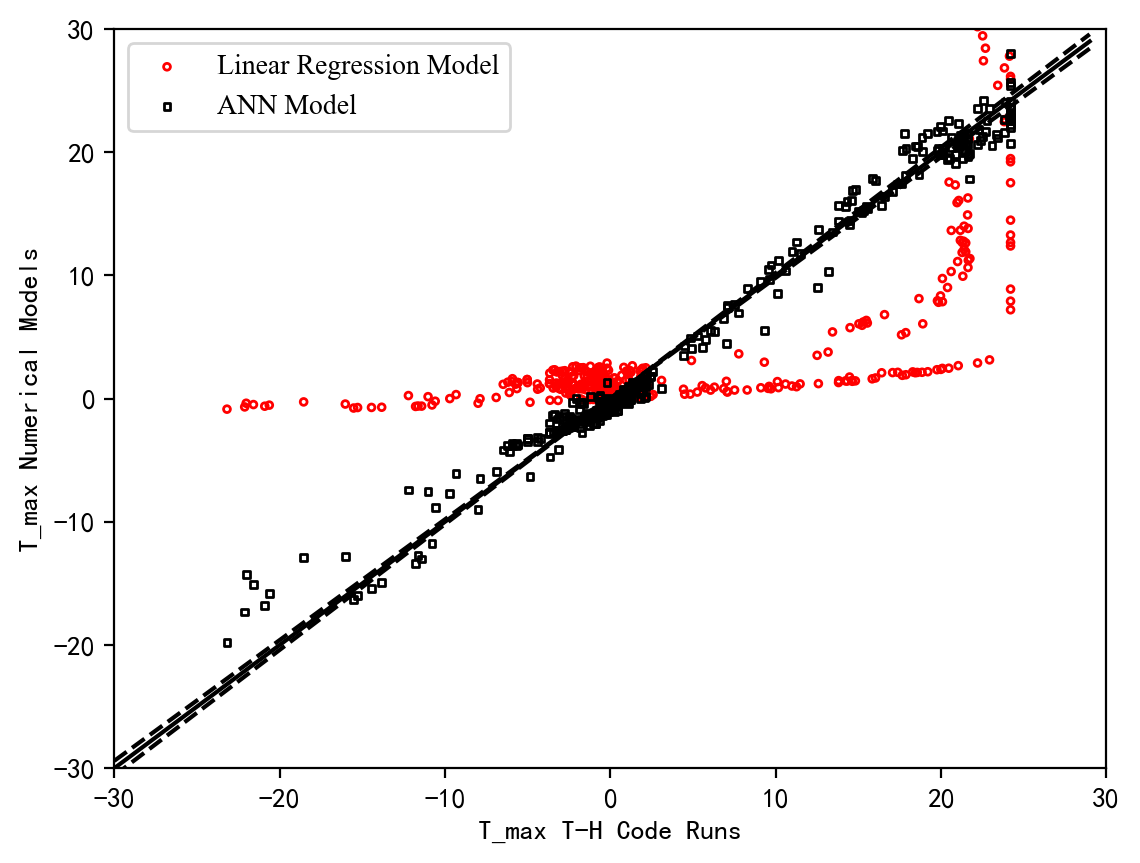

In [214]:
x_plt = np.arange(-30, 30, 1)
y_09 = 0.98*x_plt
y_11 = 1.02*x_plt
plt.figure(dpi = 200)
plt.scatter(z_data, z_LR, s=6, marker='o', c='none', edgecolors='r', label='Linear Regression Model')
plt.scatter(z_data, z_ANN, s=6, marker='s', c='none', edgecolors='k', label='ANN Model')
# plt.scatter(y_t, z_ANN, s=6, marker='^', c='none', edgecolors='b', label='ANN Model')
plt.plot(x_plt, y_09, c='k', linestyle='--')
plt.plot(x_plt, y_11, c='k', linestyle='--')
plt.plot(x_plt, x_plt, c='k')
font = {'family': 'Times New Roman'}
plt.legend(prop = font)
plt.xlabel('T_max T-H Code Runs')
plt.ylabel('T_max Numerical Models')
plt.xlim(-30, 30)
plt.ylim(-30, 30)
plt.show()

In [215]:
"""
---------------------------------------------------------------------------
Subset Simulation: 简单自然循环回路案例: y = 440 - RELAP5(u)
---------------------------------------------------------------------------
"""

# time_start = time.time()
# %% definition of the random variables
d      = 2          # number of dimensions
pi_pdf = list()
for i in range(d):
    pi_pdf.append(ERADist('truncatednormal','PAR',[1, 0.49, 0.02, 1.98])) # n independent rv

# correlation matrix
R = np.eye(d)   # independent case

# object with distribution information
pi_pdf = ERANataf(pi_pdf, R)    # if you want to include dependence

# %% limit state function
# g = lambda u: f(u)

# 导入神经网络模型
path = r'D:\relap5-2\TEST\model\test_1L40P_2_414.h5'
model = keras.models.load_model(path)

# 导入用于归一化的x和y
filepath = r'C:\Users\JH\Desktop\test_414(total).csv'
df = pd.read_csv(filepath)
data = df.values
x1 = data[:,0].astype('float32').reshape(-1,1)
x2 = data[:,1].astype('float32').reshape(-1,1)
x = np.hstack((x1, x2))
y = data[:,2].astype('float32').reshape(-1,1)

# g = ANN(u, model, x, y)


# %% subset simulation
for k in range(1):
    N  = 1000      # Total number of samples for each level
    # N  = 100000        # Total number of samples for each level
    p0 = 0.1         # Probability of each subset, chosen adaptively

    # Implementation of sensitivity analysis: 1 - perform, 0 - not perform
    sensitivity_analysis = 0

    # Samples return: 0 - none, 1 - final sample, 2 - all samples
    samples_return = 1

    print('\n\nSUBSET SIMULATION: ')
    [Pf_SuS, delta_SuS, b, Pf, b_sus, pf_sus, samplesU, samplesX, S_F1] = SuS(N, p0, ANN, pi_pdf, sensitivity_analysis, samples_return, model, x, y)

    # Reference values
    # The reference values for the first order indices
    S_F1_ref   = [0.0003, 0.0005]  # 这里是蒙卡结果

    # Print reference values for the first order indices
    print("\n***Reference first order Sobol' indices: ***\n", S_F1_ref)

    # # exact solution
    # pf_ex    = sp.stats.norm.cdf(-beta)
    # Pf_exact = lambda gg: sp.stats.norm.cdf(gg,beta,1)
    # gg       = np.linspace(0,7,140)

    # show p_f results
    # print('\n***Exact Pf: ', pf_ex, ' ***')
    print('***SuS Pf: ', Pf_SuS, ' ***\n')

    res = Pf_SuS
res



SUBSET SIMULATION: 
Evaluating performance function:	OK!

-Threshold intermediate level  0  =  20.37505760192871
	*aCS lambda = 0.407443514750405 	*aCS sigma = 0.407443514750405 	*aCS accrate = 0.37777777777777777

-Threshold intermediate level  1  =  16.8338565826416
	*aCS lambda = 0.3194624991557305 	*aCS sigma = 0.3194624991557305 	*aCS accrate = 0.4185606060606061

-Threshold intermediate level  2  =  12.385005950927734
	*aCS lambda = 0.32628868134838723 	*aCS sigma = 0.32628868134838723 	*aCS accrate = 0.44696969696969696

-Threshold intermediate level  3  =  0.0
	*aCS lambda = 0.43920965095883885 	*aCS sigma = 0.43920965095883885 	*aCS accrate = 0.5027777777777778

***Reference first order Sobol' indices: ***
 [0.0003, 0.0005]
***SuS Pf:  0.00017600000000000002  ***



0.00017600000000000002

In [222]:
res_i

array([0.000674, 0.00218 , 0.000315, 0.0021  , 0.0003  , 0.000738,
       0.000646, 0.000546, 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.   

In [152]:

# res_err = np.zeros(100)
# res_i = np.zeros(100)
# res_i[0] = 0.000674
# res_i[1] = 0.00218
# res_i[2] = 0.000315
# res_i[3] = 0.0021
# res_i[4] = 0.0003
# res_i[5] = 0.000738

i = 6
res_i[i+1] = res
res_err[i] = (res_i[i+1] - res_i[i])/ res_i[i]
res_err[i]

-0.15479876160990713

In [154]:
X = np.array(samplesX).ravel().reshape(-1,2)
X

array([[0.07046398, 0.11167682],
       [0.07098032, 0.10324626],
       [0.03785014, 0.06992659],
       ...,
       [0.02244203, 0.20094019],
       [0.13206642, 0.05599529],
       [0.04073244, 0.13089479]])

In [155]:
y_ANN = ANN(X, model, x, y)
y_ANN

array([[-1.05235863e+00],
       [-2.67478561e+00],
       [-2.35589790e+01],
       [-6.54559040e+00],
       [-1.90526009e+00],
       [-1.90526009e+00],
       [-4.99998093e-01],
       [-4.99998093e-01],
       [-4.53585815e+00],
       [-4.53585815e+00],
       [-6.09891796e+00],
       [-3.76836586e+00],
       [-1.47669029e+00],
       [-3.29741669e+00],
       [-8.44892979e+00],
       [-1.49380884e+01],
       [-4.23270512e+00],
       [-4.97028732e+00],
       [-1.34343719e+00],
       [-1.34343719e+00],
       [-1.23227425e+01],
       [-4.96205521e+00],
       [-6.13946152e+00],
       [-6.68987370e+00],
       [-1.06381073e+01],
       [-1.09867611e+01],
       [-6.99236298e+00],
       [-1.05994425e+01],
       [-7.24548340e-01],
       [-7.24548340e-01],
       [-3.96191978e+00],
       [-3.96191978e+00],
       [-1.52943611e+00],
       [-3.57293415e+00],
       [-7.24548340e-01],
       [-7.24548340e-01],
       [-4.10896969e+00],
       [-2.36807442e+00],
       [-3.6

In [156]:
output = np.hstack((X, y_ANN))
res = output[np.argsort(-output[:, 2])]        #对输出值降序排列（带负号就是降序）
header = ['x1', 'x2', 'y_ANN']
TargetFile = r'C:\Users\JH\Desktop\test_extra9(ANN).csv'
df = pd.DataFrame(res).drop_duplicates()       #去除重复行
df.to_csv(TargetFile, header = header, index = None)

In [157]:
filepath = r'C:\Users\JH\Desktop\test_extra9(ANN).csv'
df = pd.read_csv(filepath)
data = df.values[:30,:]

X_extra = data[:, 0:2]
y_extra = 440 - RELAP5(X_extra)
output = np.hstack((X_extra, y_extra.reshape(-1,1)))
header = ['x1', 'x2', 'y']
TargetFile = r'C:\Users\JH\Desktop\test_1-30(extra9).csv'
pd.DataFrame(output).to_csv(TargetFile, header = header, index = None)

N = 30
D:\copydir\testNo.0 already exist!
D:\copydir\testNo.1 already exist!
D:\copydir\testNo.2 already exist!
D:\copydir\testNo.3 already exist!
D:\copydir\testNo.4 already exist!
D:\copydir\testNo.5 already exist!
D:\copydir\testNo.6 already exist!
D:\copydir\testNo.7 already exist!
D:\copydir\testNo.8 already exist!
D:\copydir\testNo.9 already exist!
D:\copydir\testNo.10 already exist!
D:\copydir\testNo.11 already exist!
D:\copydir\testNo.12 already exist!
D:\copydir\testNo.13 already exist!
D:\copydir\testNo.14 already exist!
D:\copydir\testNo.15 already exist!
D:\copydir\testNo.16 already exist!
D:\copydir\testNo.17 already exist!
D:\copydir\testNo.18 already exist!
D:\copydir\testNo.19 already exist!
D:\copydir\testNo.20 already exist!
D:\copydir\testNo.21 already exist!
D:\copydir\testNo.22 already exist!
D:\copydir\testNo.23 already exist!
D:\copydir\testNo.24 already exist!
D:\copydir\testNo.25 already exist!
D:\copydir\testNo.26 already exist!
D:\copydir\testNo.27 already ex

In [ ]:
# 迭代结束

In [266]:
"""
---------------------------------------------------------------------------
Subset Simulation: 简单自然循环回路案例: y = 440 - RELAP5(u)
---------------------------------------------------------------------------
"""

time_start = time.time()
# %% definition of the random variables
d      = 2          # number of dimensions
pi_pdf = list()
for i in range(d):
    pi_pdf.append(ERADist('truncatednormal','PAR',[1, 0.49, 0.02, 1.98])) # n independent rv

# correlation matrix
R = np.eye(d)   # independent case

# object with distribution information
pi_pdf = ERANataf(pi_pdf, R)    # if you want to include dependence

# %% limit state function
# g = lambda u: f(u)

# 导入神经网络模型
path = r'D:\relap5-2\TEST\model\test_1L40P_2_414.h5'
model = keras.models.load_model(path)

# 导入用于归一化的x和y
filepath = r'C:\Users\JH\Desktop\test_414(total).csv'
df = pd.read_csv(filepath)
data = df.values
x1 = data[:,0].astype('float32').reshape(-1,1)
x2 = data[:,1].astype('float32').reshape(-1,1)
x = np.hstack((x1, x2))
y = data[:,2].astype('float32').reshape(-1,1)

# g = ANN(u, model, x, y)


# %% subset simulation
# P_res_1 = np.zeros(100)
P_res_3 = np.zeros(10)
for k in range(10):
    N  = 1000      # Total number of samples for each level
    # N  = 100000        # Total number of samples for each level
    p0 = 0.1         # Probability of each subset, chosen adaptively

    # Implementation of sensitivity analysis: 1 - perform, 0 - not perform
    sensitivity_analysis = 0

    # Samples return: 0 - none, 1 - final sample, 2 - all samples
    samples_return = 1

    print('\n\nSUBSET SIMULATION: ')
    [Pf_SuS, delta_SuS, b, Pf, b_sus, pf_sus, samplesU, samplesX, S_F1] = SuS(N, p0, ANN, pi_pdf, sensitivity_analysis, samples_return, model, x, y)

    # Reference values
    # The reference values for the first order indices
    S_F1_ref   = [0.0003, 0.0005]  # 这里是蒙卡结果

    # Print reference values for the first order indices
    print("\n***Reference first order Sobol' indices: ***\n", S_F1_ref)

    # # exact solution
    # pf_ex    = sp.stats.norm.cdf(-beta)
    # Pf_exact = lambda gg: sp.stats.norm.cdf(gg,beta,1)
    # gg       = np.linspace(0,7,140)

    # show p_f results
    # print('\n***Exact Pf: ', pf_ex, ' ***')
    print('***SuS Pf: ', Pf_SuS, ' ***\n')

    X = np.array(samplesX).ravel().reshape(-1,2)
    df = pd.DataFrame(X).drop_duplicates()       #去除重复行
    X_m = df.values[:18,:]          #只取前50个

    y_m = 440 - RELAP5(X_m)
    y_ANN = ANN(X_m, model, x, y)

    output = np.hstack((X_m, y_m.reshape(-1,1), y_ANN.reshape(-1,1)))
    res = output[np.argsort(output[:, 2])]        #对输出值升序排列
    header = ['x1', 'x2', 'y_m', 'y_ANN']
    TargetFile = r'C:\Users\JH\Desktop\z_m.csv'
    pd.DataFrame(res).to_csv(TargetFile, header = header, index = None)
    
    for i in range(len(res)):
        if res[i, 2] > 0:
            res_FC = res[0:i, :]
            break
    header = ['x1', 'x2', 'y_m', 'y_ANN']
    TargetFile = 'C:/Users/JH/Desktop/z_FC.csv'
    pd.DataFrame(res_FC).to_csv(TargetFile, header = header, index = None)

    x_FC = res_FC[:, 0:2]
    y_FC = res_FC[:, 2]

    m = len(x_FC)
    P_conditional_m = np.zeros(m)
    for i in range(m):
        ff = lambda xx: ANN(np.hstack((xx, x_FC[i, 1])).reshape(1,-1), model, x, y)
        zero_point = binary_search(ff, 0.02, 1.0, 1e-4)
        P_conditional_m[i] = truncnorm.cdf(zero_point, a = -2, b = 2, loc = 1, scale = 0.49)
        print(i)

    P_conditional_x = np.zeros(m)
    for i in range(m):
        ff = lambda xx: ANN(np.hstack((x_FC[i, 0], xx)).reshape(1,-1), model, x, y)
        zero_point = binary_search(ff, 0.02, 1.0, 1e-4)
        P_conditional_x[i] = truncnorm.cdf(zero_point, a = -2, b = 2, loc = 1, scale = 0.49)
        print(i)

    # P_res_1[k] = sum(P_conditional_x_true * P_conditional_m_true)/len(P_conditional_x_true)

    P_f = 0
    w = 0.01
    # m = 30
    m = len(x_FC)
    # for i in range(len(x_FC)):
    for i in range(m):
        # f_x = truncnorm.pdf(x_FC[i, 0], a = -5, b = 5, loc = 0, scale = 1) * truncnorm.pdf(x_FC[i, 1], a = -5, b = 5, loc = 0, scale = 1)
        f_x = 1
        g_x = 0
        for j in range(m):
            if ANN(np.hstack((x_FC[i, 0], x_FC[j, 1])).reshape(1,-1), model, x, y) < 0:
                g_x = g_x + f_x /(P_conditional_m[j] * P_conditional_x[i])
                # print(m_true)
            # g_x = g_x + f_x /1.162e-5
        g_x = g_x / m
        if g_x != 0:
            P_f = P_f + f_x / g_x
        print(i)
    # P_f = P_f / len(x_FC)
    P_f = P_f / m
    P_res_3[k] = P_f
    print(P_f)
    print('k = %d'%k)
time_end = time.time()
time_CPU_3 = time_end - time_start



SUBSET SIMULATION: 
Evaluating performance function:	OK!

-Threshold intermediate level  0  =  20.385662460327147
	*aCS lambda = 0.4408257224298274 	*aCS sigma = 0.4408257224298274 	*aCS accrate = 0.4061728395061729

-Threshold intermediate level  1  =  17.82634925842285
	*aCS lambda = 0.3311400609139264 	*aCS sigma = 0.3311400609139264 	*aCS accrate = 0.3903093434343434

-Threshold intermediate level  2  =  12.161774444580079
	*aCS lambda = 0.37389139083426565 	*aCS sigma = 0.37389139083426565 	*aCS accrate = 0.47160493827160493

-Threshold intermediate level  3  =  0.0
	*aCS lambda = 0.3820354047688637 	*aCS sigma = 0.3820354047688637 	*aCS accrate = 0.4521875

***Reference first order Sobol' indices: ***
 [0.0003, 0.0005]
***SuS Pf:  0.00019900000000000007  ***

N = 18
D:\copydir\testNo.0 already exist!
D:\copydir\testNo.1 already exist!
D:\copydir\testNo.2 already exist!
D:\copydir\testNo.3 already exist!
D:\copydir\testNo.4 already exist!
D:\copydir\testNo.5 already exist!
D:\co

	*aCS lambda = 0.44002604430322556 	*aCS sigma = 0.44002604430322556 	*aCS accrate = 0.49100378787878785

-Threshold intermediate level  3  =  0.0
	*aCS lambda = 0.4509803494216554 	*aCS sigma = 0.4509803494216554 	*aCS accrate = 0.43098958333333337

***Reference first order Sobol' indices: ***
 [0.0003, 0.0005]
***SuS Pf:  0.0003180000000000001  ***

N = 18
D:\copydir\testNo.0 already exist!
D:\copydir\testNo.1 already exist!
D:\copydir\testNo.2 already exist!
D:\copydir\testNo.3 already exist!
D:\copydir\testNo.4 already exist!
D:\copydir\testNo.5 already exist!
D:\copydir\testNo.6 already exist!
D:\copydir\testNo.7 already exist!
D:\copydir\testNo.8 already exist!
D:\copydir\testNo.9 already exist!
D:\copydir\testNo.10 already exist!
D:\copydir\testNo.11 already exist!
D:\copydir\testNo.12 already exist!
D:\copydir\testNo.13 already exist!
D:\copydir\testNo.14 already exist!
D:\copydir\testNo.15 already exist!
D:\copydir\testNo.16 already exist!
D:\copydir\testNo.17 already exist!
0

In [267]:
P_res_3

array([0.00040804, 0.00029655, 0.00046481, 0.00046481, 0.00046481,
       0.00041824, 0.00040194, 0.00040194, 0.0003886 , 0.00031861])

In [244]:
np.mean(P_res_1), np.var(P_res_1), min(P_res_1), max(P_res_1), time_CPU_1

(0.0003475999999999993,
 4.734399999999973e-10,
 0.00030399999999999937,
 0.00038399999999999914,
 108.49990034103394)

In [27]:
np.mean(P_res_2), np.var(P_res_2), min(P_res_2), max(P_res_2), time_CPU_2

(1.0975844725615068e-05,
 1.0658308997369184e-13,
 9.68511901007831e-06,
 1.1890703912636719e-05,
 169.03784847259521)

In [232]:
np.mean(P_res_3[:10]), np.var(P_res_3[:10]), min(P_res_3[:10]), max(P_res_3[:10]), time_CPU_3

(0.0004190274706745112,
 6.111142921742626e-10,
 0.0003712337589923812,
 0.0004675984538989133,
 922.8885173797607)

In [256]:
np.mean(P_res_3[:75]), np.var(P_res_3[:75]), min(P_res_3[:75]), max(P_res_3[:75]), time_CPU_3

(0.00041425808566317385,
 1.2576008175057835e-09,
 0.00034693465666522027,
 0.000589266253656299,
 922.8885173797607)

In [268]:
np.mean(P_res_3), np.var(P_res_3), min(P_res_3), max(P_res_3), time_CPU_3

(0.00040283517252046345,
 3.0381780235963218e-09,
 0.00029654863360819395,
 0.0004648094045641363,
 2592.300709962845)

In [ ]:
time_CPU_3

In [ ]:
4429.6+6739.9

11169.5

In [ ]:
3740.8+6359.3

10100.1

In [ ]:
3506.3+6831.1

10337.400000000001

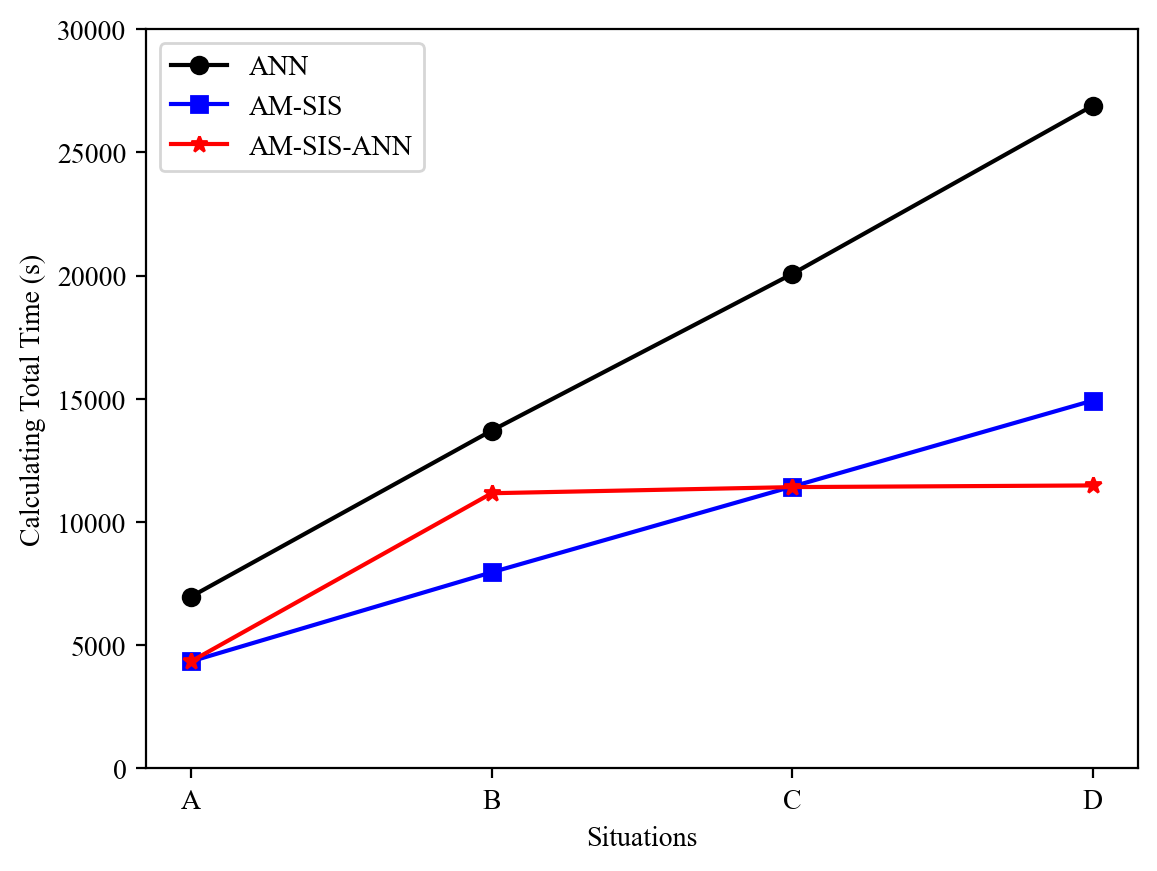

In [9]:
plt.rcParams["font.family"] = "Times New Roman"   # 全局设置字体
x_plt = ['A', 'B', 'C', 'D']
y1 = [6972.5, 6972.5+6739.5, 6972.5+6739.5+6359.3, 6972.5+6739.5+6359.3+6831.1]
y2 = [4345.4, 4345.4+3614.4, 4345.4+3614.4+3480.2, 4345.4+3614.4+3480.2+3492.3]
y3 = [4345.4, 11169.5, 11169.5+3740.8-3492.3, 11169.5+3740.8-3492.3+3560.3-3492.3]
plt.figure(dpi = 200)

plt.plot(x_plt, y1, 'ko-', label = 'ANN')
plt.plot(x_plt, y2, 'bs-', label = 'AM-SIS')
plt.plot(x_plt, y3, 'r*-', label = 'AM-SIS-ANN')

font = {'family': 'Times New Roman'}
plt.legend(prop = font)
plt.xlabel('Situations')
plt.ylabel('Calculating Total Time (s)')
# plt.xlim(0, 12)
plt.ylim(0, 30000)

plt.show()

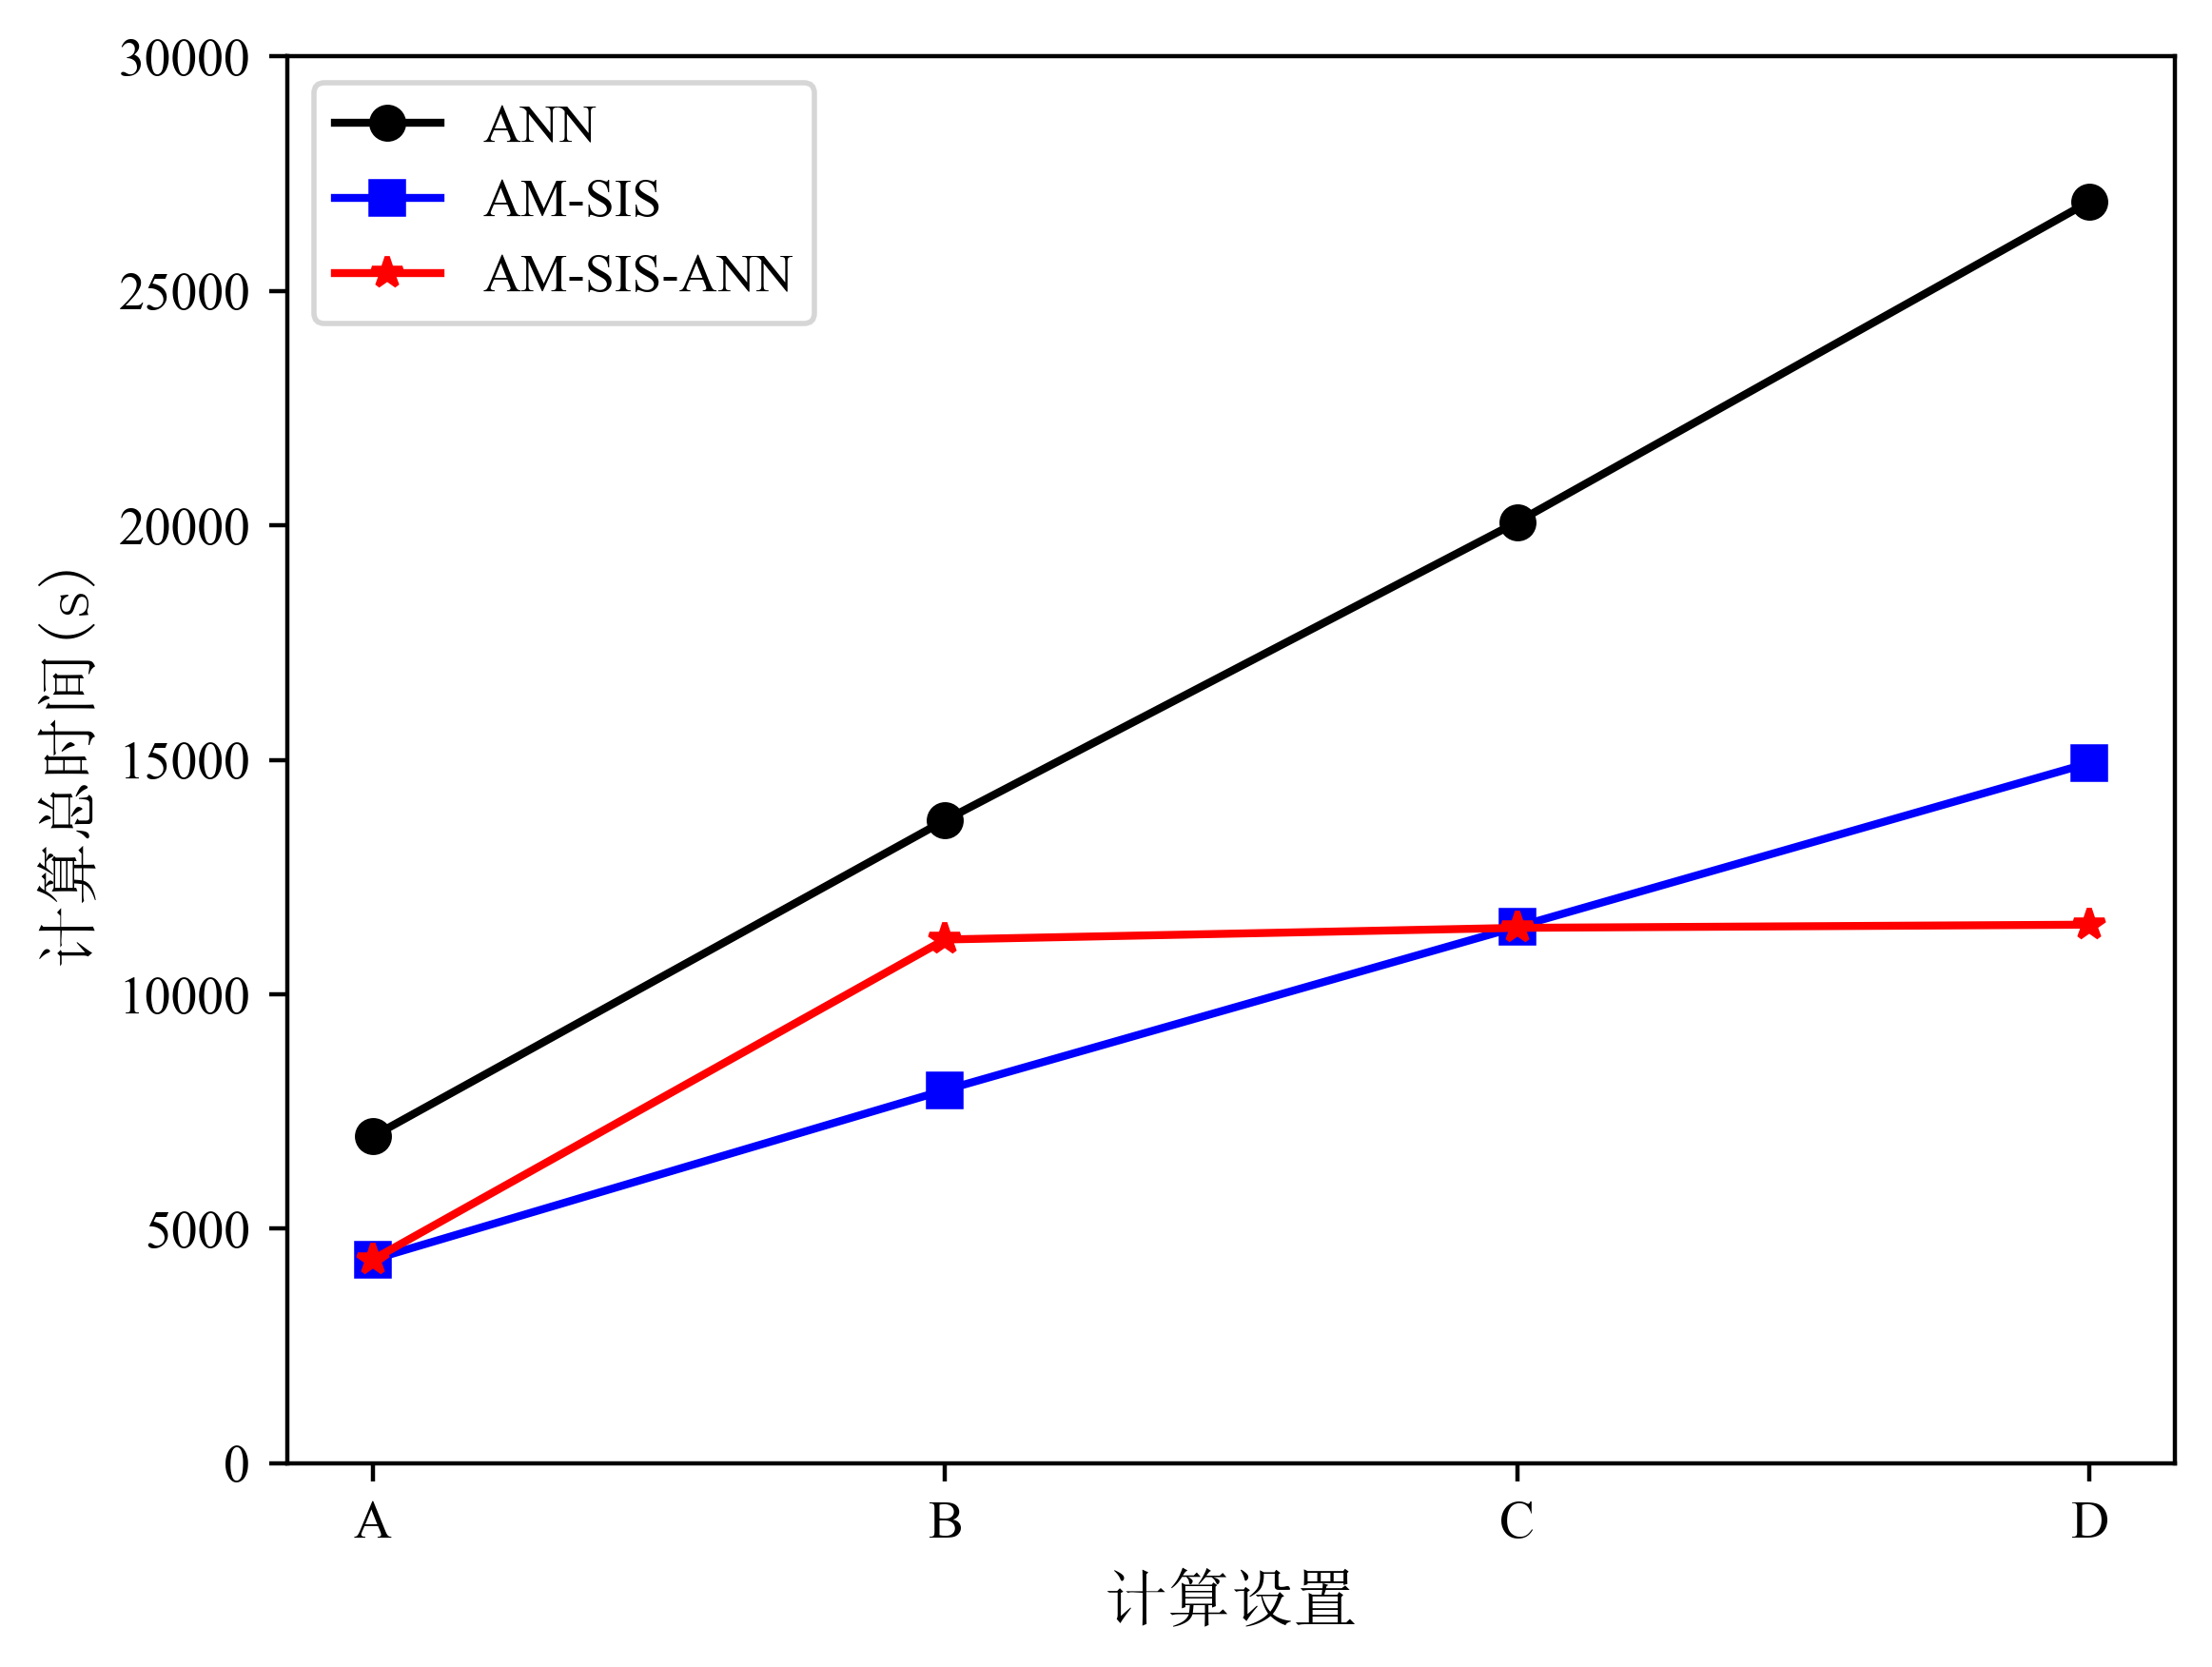

In [24]:

plt.rcParams["font.family"] = "Times New Roman"   # 全局设置字体
# config = {
        # "font.family": 'serif',
        # "mathtext.fontset": 'stix',  # matplotlib渲染数学字体时使用的字体，和Times New Roman差别不大
        # "font.serif": ['SimSun'],  # 宋体
        # 'axes.unicode_minus': False  # 处理负号，即-号
    # }
# plt.rcParams.update(config)
 

x_plt = ['A', 'B', 'C', 'D']
y1 = [6972.5, 6972.5+6739.5, 6972.5+6739.5+6359.3, 6972.5+6739.5+6359.3+6831.1]
y2 = [4345.4, 4345.4+3614.4, 4345.4+3614.4+3480.2, 4345.4+3614.4+3480.2+3492.3]
y3 = [4345.4, 11169.5, 11169.5+3740.8-3492.3, 11169.5+3740.8-3492.3+3560.3-3492.3]
plt.figure(dpi = 400)

plt.plot(x_plt, y1, 'ko-', label = 'ANN')
plt.plot(x_plt, y2, 'bs-', label = 'AM-SIS')
plt.plot(x_plt, y3, 'r*-', label = 'AM-SIS-ANN')

font1 = {'family': 'Times New Roman'}
plt.legend(prop = font1)
font2 =  {'family': 'SimSun'}
plt.xlabel('计算设置', fontproperties=font2, fontsize=12)
plt.ylabel('计算总时间(s)', fontproperties=font2, fontsize=12)
# plt.xlim(0, 12)
plt.ylim(0, 30000)

plt.show()